In [1]:
!pip install catboost
!pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
# !pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# import optuna
# from optuna import Trial
# from optuna.samplers import TPESampler
import tensorflow as tf
from tqdm import tqdm
from transformers import BertTokenizer, TFBertModel

import sys
sys.path.append('/home/elicer')

import os
os.chdir('/home/elicer/')

pd.set_option('display.max_columns', None)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-07 01:53:21.449703: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 01:53:21.501063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 01:53:22.376411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
df_test = pd.read_csv("/home/elicer/submission.csv") # 테스트 데이터(제출파일의 데이터)
df_test

,id,bant_submit,expected_budget,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,lead_date,customer_type,customer_history,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_from_channel,lead_description,lead_desc_length,event_name,inquiry_type,prefer_ver_count,prefer_ver_mean,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,transfer_agreement,ver_cus,ver_pro,ver_win_rate_x,ver_win_rate_mean_upper,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,2547,0.25,NaN,Corporate / /,ID,0.044643,19119,2023-07-12,End Customer,New,SMB,NaN,1.0,NaN,1.0,NaN,[premql]us_id__20230701,NaN,309,ID_US_Event_COCC Partners Expo_20230614,Quotation or Purchase Consultation,0.211618,0.027756,NaN,NaN,NaN,Corporate / /,none,LGEUS,NaN,NaN,1,0,0.003079,0.0,0.064566,corporate / office,Others,194,0
1,32086,1.00,"Less than $10,000",/ Ahmedabad / India,AS,0.147059,35859,2023-08-05,End Customer,New,Enterprise,NaN,NaN,NaN,NaN,administrative,lg.com(local),i have an old system need to be replaced,40,AS_IL_LG.com_I2B_2022,Quotation or Purchase Consultation,0.057692,0.005677,vrf,NaN,NaN,/ Ahmedabad / India,manager,LGEIL,less than 3 months,NaN,1,0,0.000572,0.0,0.051471,education,Institute & Academy,50,1
2,32209,1.00,"$10,000 ~ $50,000",/ 122505 / India,AS,0.461538,38658,2023-08-20,End Customer,New,SMB,NaN,NaN,NaN,NaN,engineering,lg.com(local),"WE WANT TO PURCHASE , WHICH WILL BE COMPATIBLE...",76,AS_IL_LG.com_I2B_2022,Quotation or Purchase Consultation,0.076923,0.019648,multi-split,NaN,NaN,/ 122505 / India,manager,LGEIL,less than 3 months,NaN,0,0,0.000060,1.0,0.128571,hospital & health care,Hospital,9,1
3,27680,1.00,OnGoing,/Shiekh Zayed/Egypt,AS,NaN,29043,2023-06-20,End Customer,New,Enterprise,NaN,NaN,NaN,NaN,human resources,facebook,Product estimated budget,24,AS_EG_facebookleadscampaign_May2023,Quotation or Purchase Consultation,NaN,NaN,etc.,NaN,NaN,/Shiekh Zayed/Egypt,director,LGEEG,3 months ~ 6 months,Y,0,0,NaN,NaN,NaN,NaN,NaN,51,0
4,35109,1.00,"Less than $10,000",/Cochin/India,ID,0.028926,42617,2023-06-08,Channel Partner,New,SMB,NaN,NaN,NaN,NaN,administrative,lg.com(local),"Lookign for best price, We are doing signage b...",145,ID_IL_LG.com_I2B,Quotation or Purchase Consultation,0.145228,0.103511,standard signage,UH7F-H Series,65UH7F-H,/Cochin/India,ceo/founder,LGEIL,less than 3 months,Y,0,1,0.001183,0.0,0.049840,retail,NaN,174,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21336,26080,0.25,NaN,/ São Paulo / Brazil,AS,NaN,31080,2023-07-31,NaN,New,Enterprise,NaN,NaN,NaN,NaN,others,webinar,N|A,3,AS_SP_Webinar_Integrated_SeminarDate(220322)_C...,NaN,NaN,NaN,multi-split,NaN,NaN,/ São Paulo / Brazil,others,LGESP,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,97,0
21337,65292,1.00,"$400,000 ~ $600,000",/LIMA/Peru,AS,NaN,43632,2023-06-20,NaN,Existing,SMB,271.0,NaN,NaN,NaN,engineering,webinar,NaN,3,Cursos Online Junio 2023,Others,NaN,NaN,multi-split,NaN,NaN,/LIMA/Peru,others,LGEPR,6 months ~ 9 months,Y,0,0,NaN,NaN,NaN,NaN,NaN,741,0
21338,27489,1.00,OnGoing,/ Vijayawada / India,AS,NaN,39855,2023-08-30,Specifier/ Influencer,New,SMB,NaN,NaN,NaN,NaN,purchasing,lg.com(local),"Dear Sir / MXXXXX, Require best quote for sup...",247,AS_IL_LG.com_I2B_2022,Quotation or Purchase Consultation,NaN,NaN,single-split,NaN,NaN,/ Vijayawada / India,associate/analyst,LGEIL,less than 3 months,NaN,0,0,NaN,NaN,NaN,NaN,NaN,673,0
21339,62108,0.50,NaN,/ Medellín / Colombia,AS,NaN,47466,2023-09-15,End Customer,Existing,Enterprise,16.0,NaN,NaN,NaN,NaN,lg.com(local),NaN,105,AS_CB_LG.com_I2B_2022,Quotation or Purchase Consultation,NaN,NaN,multi-split,NaN,NaN,/ Medellín / Colombia,none,LGECB,less than 3 months,NaN,0,0,NaN,NaN,NaN,NaN,NaN,39,0


In [3]:
def divide_columns_by_type(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    return numerical_cols, categorical_cols

In [4]:
target = "is_converted"
df_train = pd.read_csv("/home/elicer/train.csv") # 학습용 데이터
df_test = pd.read_csv("/home/elicer/submission.csv") # 테스트 데이터(제출파일의 데이터)
df_train[target] = df_train[target].apply(lambda x : 1 if x else 0)

In [5]:
df_test['len_expected_timeline'] = df_test['expected_timeline'].replace('_', ' ')
df_train['len_expected_timeline'] = df_train['expected_timeline'].replace('_', ' ')
def lenfuc(x):
    if isinstance(x,str):
        return len(list(x))
df_test['len_expected_timeline'] = df_test['expected_timeline'].apply(lenfuc)
df_train['len_expected_timeline'] = df_train['expected_timeline'].apply(lenfuc)
df_train['len_expected_timeline'] = df_train['len_expected_timeline'].fillna(0)
df_test['len_expected_timeline'] = df_test['len_expected_timeline'].fillna(0)
def add_countrycoinside(df, customercountry, workcountry, countrycoinside):
    df[countrycoinside] = (df[customercountry] == df[workcountry]).astype(int)
    return df
df_test = add_countrycoinside(df_test, "customer_country", "customer_country.1", "country_coinside")
df_train = add_countrycoinside(df_train, "customer_country", "customer_country.1","country_coinside")
df_train['lead_owner_job'] = df_train.groupby('lead_owner')['lead_owner'].transform('count')
df_test['lead_owner_job'] = df_test.groupby('lead_owner')['lead_owner'].transform('count')
df_train['customer_idx_count'] = df_train.groupby('customer_idx')['customer_idx'].transform('count')
df_test['customer_idx_count'] = df_test.groupby('customer_idx')['customer_idx'].transform('count')
df_train['oppty'] = df_train['customer_idx_count']/df_train['customer_idx_count'].mean() + df_train['lead_owner_job']/df_train['lead_owner_job'].mean()
df_test['oppty'] = df_test['customer_idx_count']/df_test['customer_idx_count'].mean() + df_test['lead_owner_job']/df_test['lead_owner_job'].mean()
# drop_list = ["customer_idx_count"]
# df_test = df_test.drop(drop_list, axis=1)
# df_train = df_train.drop(drop_list, axis=1)
df_train['id_strategic_ver'] = df_train['id_strategic_ver'].fillna(0)
df_train['it_strategic_ver'] = df_train['it_strategic_ver'].fillna(0)
df_test['id_strategic_ver'] = df_test['id_strategic_ver'].fillna(0)
df_test['it_strategic_ver'] = df_test['it_strategic_ver'].fillna(0)
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(0)
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(0)
df_test['ver_cus'] = df_test['ver_cus'].fillna(0)
df_test['ver_cus'] = df_test['ver_cus'].fillna(0)
df_train['vertical_level'] = np.where(((df_train['business_unit']=='ID') & (df_train['id_strategic_ver'] == 0)) | ((df_train['business_unit']=='IT') & (df_train['it_strategic_ver'] == 0)) | (df_train['com_reg_ver_win_rate'] == 0) | ((df_train['ver_cus'] == 0) & (df_train['customer_type'] == 'End-user')) ,0,1)
df_test['vertical_level'] = np.where(((df_test['business_unit']=='ID') & (df_test['id_strategic_ver'] == 0)) | ((df_test['business_unit']=='IT') & (df_test['it_strategic_ver'] == 0)) | (df_test['com_reg_ver_win_rate'] == 0) | ((df_test['ver_cus'] == 0) & (df_test['customer_type'] == 'End-user')) ,0,1)
df_train['expected_timeline'] = df_train['expected_timeline'].fillna('')
df_train['weight_expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 1 if 'month' in x or 'year' in x else 0)
df_test['expected_timeline'] = df_test['expected_timeline'].fillna('')
df_test['weight_expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 1 if 'month' in x or 'year' in x else 0)
df_train['com_reg_ver_win_rate_qcut'] = pd.qcut(df_train['com_reg_ver_win_rate'], 5, labels = False, duplicates = "drop")
df_test['com_reg_ver_win_rate_qcut'] = pd.qcut(df_test['com_reg_ver_win_rate'], 5, labels = False, duplicates = "drop")
df_train['customer_idx_count_qcut'] = pd.qcut(df_train['customer_idx_count'], 5, labels = False, duplicates = "drop")
df_test['customer_idx_count_qcut'] = pd.qcut(df_test['customer_idx_count'], 5, labels = False, duplicates = "drop")
#$ df_train['len_expected_timeline_qcut'] = pd.qcut(df_train['len_expected_timeline'], 5, labels = False, duplicates = "drop")
#$ df_test['len_expected_timeline_qcut'] = pd.qcut(df_test['len_expected_timeline'], 5, labels = False, duplicates = "drop")
df_train['lead_owner_job_qcut'] = pd.qcut(df_train['lead_owner_job'], 5, labels = False, duplicates = "drop")
df_test['lead_owner_job_qcut'] = pd.qcut(df_test['lead_owner_job'], 5, labels = False, duplicates = "drop")
df_train['oppty_qcut'] = pd.qcut(df_train['oppty'], 5, labels = False, duplicates = "drop")
df_test['oppty_qcut'] = pd.qcut(df_test['oppty'], 5, labels = False, duplicates = "drop")
df_train['historical_existing_cnt_qcut'] = pd.qcut(df_train['historical_existing_cnt'], 3, labels = False, duplicates = "drop")
df_test['historical_existing_cnt_qcut'] = pd.qcut(df_test['historical_existing_cnt'], 3, labels = False, duplicates = "drop")
df_train['lead_desc_length_qcut'] = pd.qcut(df_train['lead_desc_length'], 5, labels = False, duplicates = "drop")
df_test['lead_desc_length_qcut'] = pd.qcut(df_test['lead_desc_length'], 5, labels = False, duplicates = "drop")
#$ df_train['ver_win_rate_x_qcut'] = pd.qcut(df_train['ver_win_rate_x'], 5, labels = False, duplicates = "drop")
#$ df_test['ver_win_rate_x_qcut'] = pd.qcut(df_test['ver_win_rate_x'], 5, labels = False, duplicates = "drop")
#$ df_train['ver_win_ratio_per_bu_qcut'] = pd.qcut(df_train['ver_win_ratio_per_bu'], 5, labels = False, duplicates = "drop")
#$ df_test['ver_win_ratio_per_bu_qcut'] = pd.qcut(df_test['ver_win_ratio_per_bu'], 5, labels = False, duplicates = "drop")
df_train['prefer_ver_count_qcut'] = pd.qcut(df_train['prefer_ver_count'], 3, labels = False, duplicates = "drop")
df_test['prefer_ver_count_qcut'] = pd.qcut(df_test['prefer_ver_count'], 3, labels = False, duplicates = "drop")
df_train['prefer_ver_mean_qcut'] = pd.qcut(df_train['prefer_ver_mean'], 3, labels = False, duplicates = "drop")
df_test['prefer_ver_mean_qcut'] = pd.qcut(df_test['prefer_ver_mean'], 3, labels = False, duplicates = "drop")

def add_vertical1_probability(df):
    df['vertical1_probability'] = (
        ((df['ver_win_ratio_per_bu'] == 1) |
         (df['ver_pro'] == 1) |
         (df['ver_cus'] == 1) |
         (df['idit_strategic_ver'] == 1)) *
        df['prefer_ver_count']
    )
    return df

def add_business_vertical_probability(df):
    df['business_vertical_probability'] = df['ver_win_ratio_per_bu']*df['com_reg_ver_win_rate'] 
    return df
#business_area, business_subarea 넣는 함수
def fillna_with_others(df, column):
    df[column].fillna('others', inplace=True)
    return df
#historical_existing_cnt의 결측값 채우기
def fill_na_historical_existing_cnt(df):
    df.loc[(df['customer_history'] == 'New') & (df['historical_existing_cnt'].isna()), 'historical_existing_cnt'] = 0
    return df
#customer_job에 적용
def fillna_with_other(df):
    df['customer_job'] = df['customer_job'].apply(lambda x: 'other' if x == 'others' else x)
    df['customer_job'].fillna('other', inplace=True)
    value_counts = df['customer_job'].value_counts()
    for value, count in value_counts.items():
        if count <= 100:
            df['customer_job'].replace(value, 'other', inplace=True)
    return df



#add_vertical1_probability(df_train)
#add_vertical1_probability(df_test)
#add_business_vertical_probability(df_train)
#add_business_vertical_probability(df_test)
#fillna_with_others(df_train, 'business_area')
#fillna_with_others(df_train, 'business_subarea')
#fillna_with_others(df_test, 'business_area')
#fillna_with_others(df_test, 'business_subarea')
#fill_na_historical_existing_cnt(df_train)
#fill_na_historical_existing_cnt(df_test)
#fillna_with_other(df_train)
#fillna_with_other(df_test)

def derive_year_month(temp_df, temp_df_test) :

    df_ld  = temp_df['lead_date']
    df_ld_test = temp_df_test['lead_date']

    # 연도-월 추출
    ld_year_month = list(map(lambda x : '-'.join(x.split('-')[0:2]), df_ld))
    ld_year_month_test = list(map(lambda x : '-'.join(x.split('-')[0:2]), df_ld_test))
    
    temp_df = temp_df.drop(['lead_date'], axis = 1)
    temp_df_test = temp_df_test.drop(['lead_date'], axis = 1)
    
    temp_df['lead_date_yearmonth'] = ld_year_month
    temp_df_test['lead_date_yearmonth'] = ld_year_month_test
    
    return temp_df, temp_df_test
df_train, df_test = derive_year_month(df_train, df_test)
def add_event_second_feature(df):
    df['second_event'] = df['event_name'].str.split('_', 1).str[1].str.split('_', 1).str[0]
    return df
add_event_second_feature(df_train)
add_event_second_feature(df_test)
def add_is_fresh_feature(df):
    df['is_fresh'] = 0  # 기본값을 'not fresh'로 설정
    # 'customer_history'가 0이고 'historical_existing_cnt'가 결측치인 경우 'fresh'로 설정
    df.loc[(df['customer_history'] == 0) & (df['historical_existing_cnt'].isna()), 'is_fresh'] = 1
    return df
add_is_fresh_feature(df_train)
add_is_fresh_feature(df_test)

/tmp/ipykernel_184344/3769545981.py:125: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df['second_event'] = df['event_name'].str.split('_', 1).str[1].str.split('_', 1).str[0]
/tmp/ipykernel_184344/3769545981.py:125: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df['second_event'] = df['event_name'].str.split('_', 1).str[1].str.split('_', 1).str[0]


,id,bant_submit,expected_budget,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,customer_history,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_from_channel,lead_description,lead_desc_length,event_name,inquiry_type,prefer_ver_count,prefer_ver_mean,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,transfer_agreement,ver_cus,ver_pro,ver_win_rate_x,ver_win_rate_mean_upper,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,len_expected_timeline,country_coinside,lead_owner_job,customer_idx_count,oppty,vertical_level,weight_expected_timeline,com_reg_ver_win_rate_qcut,customer_idx_count_qcut,lead_owner_job_qcut,oppty_qcut,historical_existing_cnt_qcut,lead_desc_length_qcut,prefer_ver_count_qcut,prefer_ver_mean_qcut,lead_date_yearmonth,second_event,is_fresh
0,2547,0.25,NaN,Corporate / /,ID,0.044643,19119,End Customer,New,SMB,NaN,1.0,0.0,1.0,NaN,[premql]us_id__20230701,NaN,309,ID_US_Event_COCC Partners Expo_20230614,Quotation or Purchase Consultation,0.211618,0.027756,NaN,NaN,NaN,Corporate / /,none,LGEUS,,NaN,1,0,0.003079,0.0,0.064566,corporate / office,Others,194,0,0.0,1,833,22,0.923747,1,0,1,2,3,3,NaN,4,1.0,0.0,2023-07,US,0
1,32086,1.00,"Less than $10,000",/ Ahmedabad / India,AS,0.147059,35859,End Customer,New,Enterprise,NaN,0.0,0.0,NaN,administrative,lg.com(local),i have an old system need to be replaced,40,AS_IL_LG.com_I2B_2022,Quotation or Purchase Consultation,0.057692,0.005677,vrf,NaN,NaN,/ Ahmedabad / India,manager,LGEIL,less than 3 months,NaN,1,0,0.000572,0.0,0.051471,education,Institute & Academy,50,1,18.0,1,1,2,0.013143,1,1,1,0,0,0,NaN,3,0.0,0.0,2023-08,IL,0
2,32209,1.00,"$10,000 ~ $50,000",/ 122505 / India,AS,0.461538,38658,End Customer,New,SMB,NaN,0.0,0.0,NaN,engineering,lg.com(local),"WE WANT TO PURCHASE , WHICH WILL BE COMPATIBLE...",76,AS_IL_LG.com_I2B_2022,Quotation or Purchase Consultation,0.076923,0.019648,multi-split,NaN,NaN,/ 122505 / India,manager,LGEIL,less than 3 months,NaN,0,0,0.000060,1.0,0.128571,hospital & health care,Hospital,9,1,18.0,1,80,2,0.088027,1,1,1,0,1,1,NaN,3,0.0,0.0,2023-08,IL,0
3,27680,1.00,OnGoing,/Shiekh Zayed/Egypt,AS,0.000000,29043,End Customer,New,Enterprise,NaN,0.0,0.0,NaN,human resources,facebook,Product estimated budget,24,AS_EG_facebookleadscampaign_May2023,Quotation or Purchase Consultation,NaN,NaN,etc.,NaN,NaN,/Shiekh Zayed/Egypt,director,LGEEG,3 months ~ 6 months,Y,0,0,NaN,NaN,NaN,NaN,NaN,51,0,19.0,1,347,1,0.335018,0,1,0,0,2,2,NaN,2,NaN,NaN,2023-06,EG,0
4,35109,1.00,"Less than $10,000",/Cochin/India,ID,0.028926,42617,Channel Partner,New,SMB,NaN,0.0,0.0,NaN,administrative,lg.com(local),"Lookign for best price, We are doing signage b...",145,ID_IL_LG.com_I2B,Quotation or Purchase Consultation,0.145228,0.103511,standard signage,UH7F-H Series,65UH7F-H,/Cochin/India,ceo/founder,LGEIL,less than 3 months,Y,0,1,0.001183,0.0,0.049840,retail,NaN,174,0,18.0,1,1959,1,1.863028,0,1,0,0,3,3,NaN,4,1.0,2.0,2023-06,IL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21336,26080,0.25,NaN,/ São Paulo / Brazil,AS,0.000000,31080,NaN,New,Enterprise,NaN,0.0,0.0,NaN,others,webinar,N|A,3,AS_SP_Webinar_Integrated_SeminarDate(220322)_C...,NaN,NaN,NaN,multi-split,NaN,NaN,/ São Paulo / Brazil,others,LGESP,,NaN,0,0,NaN,NaN,NaN,NaN,NaN,97,0,0.0,1,3783,1,3.591992,0,0,0,0,4,3,NaN,0,NaN,NaN,2023-07,SP,0
21337,65292,1.00,"$400,000 ~ $600,000",/LIMA/Peru,AS,0.000000,43632,NaN,Existing,SMB,271.0,0.0,0.0,NaN,engineering,webinar,NaN,3,Cursos Online Junio 2023,Others,NaN,NaN,multi-split,NaN,NaN,/LIMA/Peru,others,LGEPR,6 months ~ 9 months,Y,0,0,NaN,NaN,NaN,NaN,NaN,741,0,19.0,1,6,1,0.011785,0,1,0,0,0,0,2.0,0,NaN,NaN,2023-06,NaN,0
21338,27489,1.00,OnGoing,/

In [6]:
# BERT 모델 정의
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
max_seq_len = 128
bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased", from_pt = False)
def sentiment_predict(new_sentence):
  input_id = tokenizer.encode(new_sentence, max_length=max_seq_len, pad_to_max_length=True, truncation = True)

  padding_count = input_id.count(tokenizer.pad_token_id)
  attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
  token_type_id = [0] * max_seq_len

  input_ids = np.array([input_id])
  attention_masks = np.array([attention_mask])
  token_type_ids = np.array([token_type_id])

  encoded_input = [input_ids, attention_masks, token_type_ids]
  score = bert_model.predict(encoded_input)[0]
  return score.mean()

2024-04-07 01:53:27.300171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38226 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:17:00.0, compute capability: 8.0
2024-04-07 01:53:28.970284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model fro

In [7]:
less_score = sentiment_predict('less than')
more_score = sentiment_predict('more than')
def score_label(x):
    if 'more' in x:
        return (more_score + 0.5)
    elif 'less' in x:
        return (less_score + 0.5)
    else:
        return 0
df_test['sentimental_expected_timeline'] = df_test['expected_timeline'].apply(score_label)
df_train['sentimental_expected_timeline'] = df_train['expected_timeline'].apply(score_label)

/home/elicer/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 35ms/step


In [8]:
drop_list = ['it_strategic_ver', 'oppty', 'vertical_level', 'customer_country', 'id_strategic_ver']
df_test = df_test.drop(drop_list, axis=1)
df_train = df_train.drop(drop_list, axis=1)

In [9]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [10]:
numerical_cols, categorical_cols = divide_columns_by_type(df_train)
def move_features(categorical_cols, numerical_cols, features_to_move):
    for feature in features_to_move:
        if feature in numerical_cols:
            categorical_cols.append(feature)
            numerical_cols.remove(feature)
    return categorical_cols, numerical_cols
features_to_move = ['customer_idx', 'lead_owner']
updated_categorical_cols, updated_numerical_cols = move_features(categorical_cols, numerical_cols, features_to_move)

In [11]:
print(f'numerical_cols: {numerical_cols}')
print()
print(f'categorical_cols: {categorical_cols}')

numerical_cols: ['bant_submit', 'com_reg_ver_win_rate', 'historical_existing_cnt', 'idit_strategic_ver', 'lead_desc_length', 'prefer_ver_count', 'prefer_ver_mean', 'ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_rate_mean_upper', 'ver_win_ratio_per_bu', 'is_converted', 'len_expected_timeline', 'country_coinside', 'lead_owner_job', 'customer_idx_count', 'weight_expected_timeline', 'com_reg_ver_win_rate_qcut', 'customer_idx_count_qcut', 'lead_owner_job_qcut', 'oppty_qcut', 'historical_existing_cnt_qcut', 'lead_desc_length_qcut', 'prefer_ver_count_qcut', 'prefer_ver_mean_qcut', 'is_fresh', 'sentimental_expected_timeline']

categorical_cols: ['expected_budget', 'business_unit', 'customer_type', 'customer_history', 'enterprise', 'customer_job', 'lead_from_channel', 'lead_description', 'event_name', 'inquiry_type', 'product_category', 'product_subcategory', 'product_modelname', 'customer_country.1', 'customer_position', 'response_corporate', 'expected_timeline', 'transfer_agreement', 'busin

In [12]:
df_train

,bant_submit,expected_budget,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,customer_history,enterprise,historical_existing_cnt,idit_strategic_ver,customer_job,lead_from_channel,lead_description,lead_desc_length,event_name,inquiry_type,prefer_ver_count,prefer_ver_mean,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,transfer_agreement,ver_cus,ver_pro,ver_win_rate_x,ver_win_rate_mean_upper,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,len_expected_timeline,country_coinside,lead_owner_job,customer_idx_count,weight_expected_timeline,com_reg_ver_win_rate_qcut,customer_idx_count_qcut,lead_owner_job_qcut,oppty_qcut,historical_existing_cnt_qcut,lead_desc_length_qcut,prefer_ver_count_qcut,prefer_ver_mean_qcut,lead_date_yearmonth,second_event,is_fresh,sentimental_expected_timeline
0,0.75,0,AS,0.000000,33931,End-Customer,Existing,Enterprise,4.0,0.0,engineering,lg.com(local),0,30,AS_IN_LG.com_I2B_2022,Quotation or purchase consultation,0.076923,0.019648,vrf,0,0,/DKI Jakarta/Indonesia,director,LGEIN,less than 3 months,Y,0,0,0.000060,1.0,0.128571,hospital & health care,General Hospital,870,0,18.0,1,3,2,1,0.0,0,0,0,1.0,2,0.0,0.0,2022-10,IN,0,0.499414
1,0.25,0,ID,0.390244,42490,0,New,SMB,0.0,0.0,0,promotion page,Are there any grants for technology available?,46,ID_US_Createboard_Campaign,Quotation or Purchase Consultation,0.095436,0.067718,0,Digital Signage or Commercial TVs,0,/Minneola/United States,none,LGEUS,,N,0,0,0.000572,0.0,0.048630,education,0,501,1,0.0,1,21,1,0,4.0,0,0,0,0.0,2,0.0,1.0,2023-05,US,0,0.000000
2,0.25,0,IT,0.000000,10350,Solution Eco-Partner,New,SMB,0.0,0.0,0,0,0,3,IT_US_Cloud_IT_VMUG_UserCon_Event_Leads_230323,Quotation or Purchase Consultation,0.000000,0.000000,0,0,0,4880 Stevens Creek Blvd Cloud IT/Hollywood/Un...,none,LGEUS,,Y,0,0,0.000000,0.0,0.000000,0,0,375,1,0.0,1,89,7,0,0.0,1,1,1,0.0,0,0.0,0.0,2023-04,US,0,0.000000
3,1.00,"$100,000 ~ $500,000",ID,0.017544,19750,0,New,SMB,0.0,0.0,education,lg.com,"Dear Ladies and Gentlemen, \n\nfor three of ou...",232,ID_HQ_LG.com_I2B,Quotation or Purchase Consultation,0.095436,0.067718,oled signage,0,0,/Wiesbaden/Germany,manager,LGEDG,less than 3 months,Y,0,0,0.000572,0.0,0.048630,education,0,359,0,18.0,1,305,2,1,1.0,0,2,2,0.0,4,0.0,1.0,2021-10,HQ,0,0.499414
4,0.50,0,ID,0.000000,45802,Specifier/ Influencer,New,SMB,0.0,0.0,marketing,lg.com(local),test,4,ID_SL_LG.com_I2B_Dev,Quotation or purchase consultation,0.000000,0.000000,video wall signage,0,0,//Singapore,none,LGESL,less than 3 months,Y,0,0,0.000000,0.0,0.000000,0,0,198,0,18.0,1,50,2,1,0.0,0,0,0,0.0,1,0.0,0.0,2023-04,SL,0,0.499414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,0.75,0,ID,0.000000,17289,0,Existing,Enterprise,3.0,0.0,sales,lg.com,"Please share quotation for 80"" 4k display. Ple...",131,ID_IL_LG.com_I2B,Quotation or purchase consultation,0.000000,0.000000,commercial display,0,0,/Noida/India,manager,LGEIL,3 months ~ 6 months,Y,0,0,0.000000,0.0,0.000000,0,0,174,0,19.0,1,4627,2,1,0.0,0,4,4,0.0,4,0.0,0.0,2021-07,IL,0,0.000000
59295,0.75,0,ID,0.000000,23686,0,New,SMB,0.0,0.0,business development,lg.com,0,31,ID_SP_LG.com_I2B,Quotation or purchase consultation,0.000000,0.000000,led signage,0,0,/Sao Bernardo do Campo/Brazil,director,LGESP,3 months ~ 6 months,Y,0,0,0.000000,0.0,0.000000,0,0,211,0,19.0,1,130,1,1,0.0,0,1,1,0.0,2,0.0,0.0,2021-07,SP,0,0.000000
59296,0.50,0,AS,0.049689,29370,0,Existing,Enterprise,1.0,0.0,accounting,lg.com(global),how much is 5 zones ac \n1.5 hp x 4\n5 hp x 1,43,AS_Global_M&A_LG.com_I2B,Sales Inquiry,0.269231,0.003494,multi-split,0,0,/Alexandria/Egypt,trainee,LGEEG,,Y,0,0,0.000298,0.0,0.020121,residential (home),0,56,0,0.0,1,127,61,0,2.0,2,1,1,0.0,2,2.0,0.0,2021-08,Global,0,0.000000
59297,0.50,0,AS,0.00

In [13]:
# object로 변환
df_all = pd.concat([df_train[categorical_cols], df_test[categorical_cols]])

for col in categorical_cols:
    df_all[[col]] = df_all[[col]].astype(dtype='object')

for col in categorical_cols:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

데이터 프레임 분리

In [14]:
df_true = df_train[df_train['is_converted'] == 1]
df_false = df_train[df_train['is_converted'] == 0]

In [15]:
df_false.iloc[:1]

,bant_submit,expected_budget,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,customer_history,enterprise,historical_existing_cnt,idit_strategic_ver,customer_job,lead_from_channel,lead_description,lead_desc_length,event_name,inquiry_type,prefer_ver_count,prefer_ver_mean,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,transfer_agreement,ver_cus,ver_pro,ver_win_rate_x,ver_win_rate_mean_upper,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,len_expected_timeline,country_coinside,lead_owner_job,customer_idx_count,weight_expected_timeline,com_reg_ver_win_rate_qcut,customer_idx_count_qcut,lead_owner_job_qcut,oppty_qcut,historical_existing_cnt_qcut,lead_desc_length_qcut,prefer_ver_count_qcut,prefer_ver_mean_qcut,lead_date_yearmonth,second_event,is_fresh,sentimental_expected_timeline
0,0.75,0,AS,0.0,33931,End-Customer,Existing,Enterprise,4.0,0.0,engineering,lg.com(local),0,30,AS_IN_LG.com_I2B_2022,Quotation or purchase consultation,0.076923,0.019648,vrf,0,0,/DKI Jakarta/Indonesia,director,LGEIN,less than 3 months,Y,0,0,0.00006,1.0,0.128571,hospital & health care,General Hospital,870,0,18.0,1,3,2,1,0.0,0,0,0,1.0,2,0.0,0.0,2022-10,IN,0,0.499414


In [16]:
df_false = df_false.sample(frac = 1, random_state= 777)

In [17]:
df_false_set = []
for i in range(int(len(df_false) / len(df_true))):
    df_false_tmp = df_false.iloc[i * len(df_true) : (i+1) * len(df_true)]
    df_false_set.append(df_false_tmp)

In [18]:
len(df_false_set)

11

In [19]:
train_set = []
for i in range(len(df_false_set)):
    train_data = pd.concat([df_false_set[i], df_true], axis = 0, ignore_index = True)
    train_shuffled = train_data.sample(frac = 1, random_state= 777)
    train_set.append(train_shuffled)

In [20]:
for i in range(len(train_set)):
    if train_set[i]['is_converted'].mean() != 0.5:
        print('오류')

In [21]:
train_set[0]

,bant_submit,expected_budget,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,customer_history,enterprise,historical_existing_cnt,idit_strategic_ver,customer_job,lead_from_channel,lead_description,lead_desc_length,event_name,inquiry_type,prefer_ver_count,prefer_ver_mean,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,transfer_agreement,ver_cus,ver_pro,ver_win_rate_x,ver_win_rate_mean_upper,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,len_expected_timeline,country_coinside,lead_owner_job,customer_idx_count,weight_expected_timeline,com_reg_ver_win_rate_qcut,customer_idx_count_qcut,lead_owner_job_qcut,oppty_qcut,historical_existing_cnt_qcut,lead_desc_length_qcut,prefer_ver_count_qcut,prefer_ver_mean_qcut,lead_date_yearmonth,second_event,is_fresh,sentimental_expected_timeline
2532,1.00,"Less than $100,000",AS,0.003937,32378,0,New,SMB,0.0,0.0,real estate,lg.com,0,186,AS_SP_LG.com_I2B,Sales Inquiry,0.288462,0.016624,teto ou cassete inverter,0,0,/Porto Alegre /Brazil,ceo/founder,LGESP,more than a year,Y,0,0,0.003079,0.0,0.026846,corporate / office,0,96,0,16.0,1,981,1,1,0.0,0,3,2,0.0,4,2.0,0.0,2022-01,SP,0,0.501164
4958,0.25,0,IT,0.642857,10941,End-Customer,New,Enterprise,0.0,0.0,0,0,0,3,IT_US_Cloud_IT_Disrupt23_Leads_20230420,Quotation or Purchase Consultation,0.434783,0.445656,0,0,0,900 Broken Sound Pkwy NW Healthcare/Boca Rato...,none,LGEUS,,Y,0,0,0.000060,1.0,0.000000,hospital & health care,Others,437,1,0.0,1,141,2,0,4.0,0,1,1,0.0,0,2.0,2.0,2023-04,US,0,0.000000
1096,0.75,"More than $1,000,000",ID,0.000000,44333,0,New,Enterprise,0.0,0.0,0,facebook,No,2,ID_IL_FB IDB Campaign_220311,Quotation or purchase consultation,0.000000,0.000000,interactive digital board,0,0,/Indore/India,ceo/founder,LGEIL,,Y,0,0,0.000000,0.0,0.000000,0,0,175,0,0.0,1,4120,12,0,0.0,1,4,3,0.0,0,0.0,0.0,2022-07,IL,0,0.000000
9453,0.75,"Less than $10,000",ID,0.000000,21779,End Customer,New,SMB,0.0,0.0,marketing,lg.com(local),0,161,ID_HK_LG.com_I2B,Quotation or Purchase Consultation,0.000000,0.000000,standard signage,0,0,//Hong Kong,none,LGEHK,less than 3 months,Y,0,0,0.000000,0.0,0.000000,0,0,337,1,18.0,1,138,1,1,0.0,0,1,1,0.0,4,0.0,0.0,2023-02,HK,0,0.499414
4661,0.25,0,AS,0.000000,10418,0,Existing,Enterprise,74.0,0.0,entrepreneurship,webinar,FTS Registration,16,AS_IL_DUBAI_GL_20220729_Qualifiers_Registratio...,Quotation or purchase consultation,0.000000,0.000000,0,0,0,/Pathanamthitta /India,none,LGEIL,,Y,0,0,0.000000,0.0,0.000000,0,0,115,0,0.0,1,734,1,0,0.0,0,3,2,2.0,1,0.0,0.0,2022-08,IL,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.50,0,ID,0.000000,47466,0,Existing,Enterprise,4.0,0.0,0,0,Quotation or purchase consultation,34,0,Quotation or purchase consultation,0.000000,0.000000,0,0,0,/coimbatore/India,none,LGEIL,less than 3 months,Y,0,0,0.000000,0.0,0.000000,0,0,174,0,18.0,1,4627,7686,1,0.0,2,4,4,1.0,2,0.0,0.0,2022-02,0,0,0.499414
5789,1.00,"$100,000 ~ $500,000",ID,0.000000,25096,0,New,Enterprise,0.0,0.0,operations,lg.com,"Hi, I am looking to get a quote for 43 inch o...",248,ID_UK_LG.com_I2B,Quotation or purchase consultation,0.000000,0.000000,standard signage,UHD TV Signage,43UR640S (EU/CIS),/Scotland/United Kingdom,director,LGEUK,less than 3 months,Y,0,0,0.000000,0.0,0.000000,0,0,186,1,18.0,1,26,2421,1,0.0,2,0,3,0.0,4,0.0,0.0,2021-12,UK,0,0.499414
4017,0.50,0,ID,0.054422,11980,0,Existing,Enterprise,1.0,0.0,administrative,lg.com,0,17,ID_CB_LG.com_I2B,Quotation or purchase consultation,0.058091,0.068288,standard signage,0,0,/Bogotá/Colombia,associate/analyst,LGECB,,Y,0,0,0.000097,1.0,0.079412,government department,0,494,0,0.0,1,130,3,0,2.0,1,1,1,0.0,1,0.0,1.0,2022-01,CB,0,0.000000
7767,0.50,0,ID,0.000000,25096,0,New,Enterprise,0.0,0.0,real estate,facebook,We

# 모델학습

## 1. CatBoost

In [22]:
# !pip install catboost

In [23]:
from catboost import CatBoostClassifier

In [24]:
# 예측에 필요한 데이터 분리
df_test = df_test.drop(["id"], axis=1)

In [25]:
f1_scores = []
accuracy_scores = []
precision_scores =[]
recall_scores = []
neg_accs = []
pos_accs = []
confusions =[]
test_preds = []


In [26]:
# 평가 함수
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

# 평가 함수
def get_neg_acc(val, pred):
    val = np.array(val)
    val2 = val[np.where(val == 0)[0]]
    pred2 = pred[np.where(val == 0)[0]]
    cnt = 0
    for v, p in zip(val2, pred2):
        if p == 0:
            cnt+=1

    return cnt/len(val2)

# 평가 함수
def get_pos_acc(val, pred):
    val = np.array(val)
    val2 = val[np.where(val == 1)[0]]
    pred2 = pred[np.where(val == 1)[0]]
    cnt = 0
    for v, p in zip(val2, pred2):
        if p == 1:
            cnt+=1

    return cnt/len(val2)

def get_mean_prediction(df, test_predict):
    mean_series = df.mean()
    
    predictions_array = np.array(test_predict)
    mean_prediction = np.mean(predictions_array)
    
    mean_series['mean_prediction'] = mean_prediction
    metrics_df = pd.DataFrame(mean_series).transpose()
    metrics_df = metrics_df.map(lambda x: f"{round(x*100, 6)}%" if pd.notnull(x) else x)
    return metrics_df

Learning rate set to 0.026101
0:	learn: 0.6539593	test: 0.6527733	best: 0.6527733 (0)	total: 83.4ms	remaining: 6m 56s
1:	learn: 0.6122764	test: 0.6102696	best: 0.6102696 (1)	total: 106ms	remaining: 4m 23s
2:	learn: 0.5800967	test: 0.5773763	best: 0.5773763 (2)	total: 126ms	remaining: 3m 30s
3:	learn: 0.5502962	test: 0.5464155	best: 0.5464155 (3)	total: 147ms	remaining: 3m 3s
4:	learn: 0.5210390	test: 0.5164849	best: 0.5164849 (4)	total: 170ms	remaining: 2m 50s
5:	learn: 0.4965289	test: 0.4913100	best: 0.4913100 (5)	total: 192ms	remaining: 2m 39s
6:	learn: 0.4752860	test: 0.4697079	best: 0.4697079 (6)	total: 212ms	remaining: 2m 31s
7:	learn: 0.4563728	test: 0.4503953	best: 0.4503953 (7)	total: 233ms	remaining: 2m 25s
8:	learn: 0.4380178	test: 0.4319725	best: 0.4319725 (8)	total: 254ms	remaining: 2m 20s
9:	learn: 0.4246453	test: 0.4179353	best: 0.4179353 (9)	total: 280ms	remaining: 2m 19s
10:	learn: 0.4040088	test: 0.3965920	best: 0.3965920 (10)	total: 300ms	remaining: 2m 16s
11:	learn: 

99:	learn: 0.1512657	test: 0.1416394	best: 0.1416394 (99)	total: 2.1s	remaining: 1m 42s
100:	learn: 0.1511126	test: 0.1416555	best: 0.1416394 (99)	total: 2.12s	remaining: 1m 42s
101:	learn: 0.1506929	test: 0.1414902	best: 0.1414902 (101)	total: 2.14s	remaining: 1m 42s
102:	learn: 0.1503218	test: 0.1410494	best: 0.1410494 (102)	total: 2.16s	remaining: 1m 42s
103:	learn: 0.1500232	test: 0.1408351	best: 0.1408351 (103)	total: 2.18s	remaining: 1m 42s
104:	learn: 0.1494946	test: 0.1403853	best: 0.1403853 (104)	total: 2.19s	remaining: 1m 42s
105:	learn: 0.1491086	test: 0.1401583	best: 0.1401583 (105)	total: 2.21s	remaining: 1m 42s
106:	learn: 0.1488534	test: 0.1400618	best: 0.1400618 (106)	total: 2.23s	remaining: 1m 42s
107:	learn: 0.1485155	test: 0.1398005	best: 0.1398005 (107)	total: 2.25s	remaining: 1m 42s
108:	learn: 0.1481269	test: 0.1395407	best: 0.1395407 (108)	total: 2.27s	remaining: 1m 41s
109:	learn: 0.1479693	test: 0.1395021	best: 0.1395021 (109)	total: 2.29s	remaining: 1m 41s
110

195:	learn: 0.1320147	test: 0.1306759	best: 0.1306759 (195)	total: 3.99s	remaining: 1m 37s
196:	learn: 0.1316828	test: 0.1303649	best: 0.1303649 (196)	total: 4.01s	remaining: 1m 37s
197:	learn: 0.1315513	test: 0.1303534	best: 0.1303534 (197)	total: 4.03s	remaining: 1m 37s
198:	learn: 0.1313306	test: 0.1303129	best: 0.1303129 (198)	total: 4.05s	remaining: 1m 37s
199:	learn: 0.1312078	test: 0.1303300	best: 0.1303129 (198)	total: 4.06s	remaining: 1m 37s
200:	learn: 0.1310416	test: 0.1302450	best: 0.1302450 (200)	total: 4.08s	remaining: 1m 37s
201:	learn: 0.1309829	test: 0.1302517	best: 0.1302450 (200)	total: 4.1s	remaining: 1m 37s
202:	learn: 0.1308437	test: 0.1301728	best: 0.1301728 (202)	total: 4.12s	remaining: 1m 37s
203:	learn: 0.1307028	test: 0.1301263	best: 0.1301263 (203)	total: 4.14s	remaining: 1m 37s
204:	learn: 0.1305146	test: 0.1299152	best: 0.1299152 (204)	total: 4.16s	remaining: 1m 37s
205:	learn: 0.1303969	test: 0.1298179	best: 0.1298179 (205)	total: 4.18s	remaining: 1m 37s


291:	learn: 0.1198126	test: 0.1249264	best: 0.1249264 (291)	total: 5.88s	remaining: 1m 34s
292:	learn: 0.1197121	test: 0.1248035	best: 0.1248035 (292)	total: 5.9s	remaining: 1m 34s
293:	learn: 0.1196622	test: 0.1248295	best: 0.1248035 (292)	total: 5.92s	remaining: 1m 34s
294:	learn: 0.1195363	test: 0.1248041	best: 0.1248035 (292)	total: 5.94s	remaining: 1m 34s
295:	learn: 0.1193686	test: 0.1247978	best: 0.1247978 (295)	total: 5.96s	remaining: 1m 34s
296:	learn: 0.1191867	test: 0.1246941	best: 0.1246941 (296)	total: 5.99s	remaining: 1m 34s
297:	learn: 0.1191239	test: 0.1246417	best: 0.1246417 (297)	total: 6.01s	remaining: 1m 34s
298:	learn: 0.1189722	test: 0.1246314	best: 0.1246314 (298)	total: 6.03s	remaining: 1m 34s
299:	learn: 0.1188989	test: 0.1246520	best: 0.1246314 (298)	total: 6.05s	remaining: 1m 34s
300:	learn: 0.1187605	test: 0.1245913	best: 0.1245913 (300)	total: 6.07s	remaining: 1m 34s
301:	learn: 0.1186753	test: 0.1245243	best: 0.1245243 (301)	total: 6.09s	remaining: 1m 34s


385:	learn: 0.1107905	test: 0.1215056	best: 0.1215056 (385)	total: 7.79s	remaining: 1m 33s
386:	learn: 0.1107370	test: 0.1215000	best: 0.1215000 (386)	total: 7.81s	remaining: 1m 33s
387:	learn: 0.1106859	test: 0.1214835	best: 0.1214835 (387)	total: 7.84s	remaining: 1m 33s
388:	learn: 0.1106267	test: 0.1214679	best: 0.1214679 (388)	total: 7.86s	remaining: 1m 33s
389:	learn: 0.1105033	test: 0.1214122	best: 0.1214122 (389)	total: 7.88s	remaining: 1m 33s
390:	learn: 0.1104983	test: 0.1214033	best: 0.1214033 (390)	total: 7.9s	remaining: 1m 33s
391:	learn: 0.1104500	test: 0.1214047	best: 0.1214033 (390)	total: 7.92s	remaining: 1m 33s
392:	learn: 0.1103060	test: 0.1213445	best: 0.1213445 (392)	total: 7.94s	remaining: 1m 33s
393:	learn: 0.1102688	test: 0.1213227	best: 0.1213227 (393)	total: 7.96s	remaining: 1m 33s
394:	learn: 0.1102621	test: 0.1213107	best: 0.1213107 (394)	total: 7.98s	remaining: 1m 33s
395:	learn: 0.1102007	test: 0.1212758	best: 0.1212758 (395)	total: 8s	remaining: 1m 33s
396

480:	learn: 0.1046573	test: 0.1196987	best: 0.1196987 (480)	total: 9.67s	remaining: 1m 30s
481:	learn: 0.1046017	test: 0.1197024	best: 0.1196987 (480)	total: 9.69s	remaining: 1m 30s
482:	learn: 0.1045602	test: 0.1197000	best: 0.1196987 (480)	total: 9.71s	remaining: 1m 30s
483:	learn: 0.1044166	test: 0.1196558	best: 0.1196558 (483)	total: 9.72s	remaining: 1m 30s
484:	learn: 0.1043622	test: 0.1196528	best: 0.1196528 (484)	total: 9.74s	remaining: 1m 30s
485:	learn: 0.1043543	test: 0.1196404	best: 0.1196404 (485)	total: 9.76s	remaining: 1m 30s
486:	learn: 0.1043320	test: 0.1196090	best: 0.1196090 (486)	total: 9.78s	remaining: 1m 30s
487:	learn: 0.1043043	test: 0.1196007	best: 0.1196007 (487)	total: 9.8s	remaining: 1m 30s
488:	learn: 0.1042194	test: 0.1195370	best: 0.1195370 (488)	total: 9.82s	remaining: 1m 30s
489:	learn: 0.1042025	test: 0.1195232	best: 0.1195232 (489)	total: 9.84s	remaining: 1m 30s
490:	learn: 0.1041489	test: 0.1195121	best: 0.1195121 (490)	total: 9.86s	remaining: 1m 30s


575:	learn: 0.0978520	test: 0.1178337	best: 0.1178337 (575)	total: 11.6s	remaining: 1m 28s
576:	learn: 0.0978355	test: 0.1178343	best: 0.1178337 (575)	total: 11.6s	remaining: 1m 28s
577:	learn: 0.0977915	test: 0.1178323	best: 0.1178323 (577)	total: 11.6s	remaining: 1m 28s
578:	learn: 0.0977824	test: 0.1178369	best: 0.1178323 (577)	total: 11.6s	remaining: 1m 28s
579:	learn: 0.0977745	test: 0.1178288	best: 0.1178288 (579)	total: 11.6s	remaining: 1m 28s
580:	learn: 0.0977523	test: 0.1178455	best: 0.1178288 (579)	total: 11.6s	remaining: 1m 28s
581:	learn: 0.0977188	test: 0.1178286	best: 0.1178286 (581)	total: 11.7s	remaining: 1m 28s
582:	learn: 0.0976739	test: 0.1178509	best: 0.1178286 (581)	total: 11.7s	remaining: 1m 28s
583:	learn: 0.0976634	test: 0.1178520	best: 0.1178286 (581)	total: 11.7s	remaining: 1m 28s
584:	learn: 0.0976461	test: 0.1178504	best: 0.1178286 (581)	total: 11.7s	remaining: 1m 28s
585:	learn: 0.0975946	test: 0.1178399	best: 0.1178286 (581)	total: 11.7s	remaining: 1m 28s

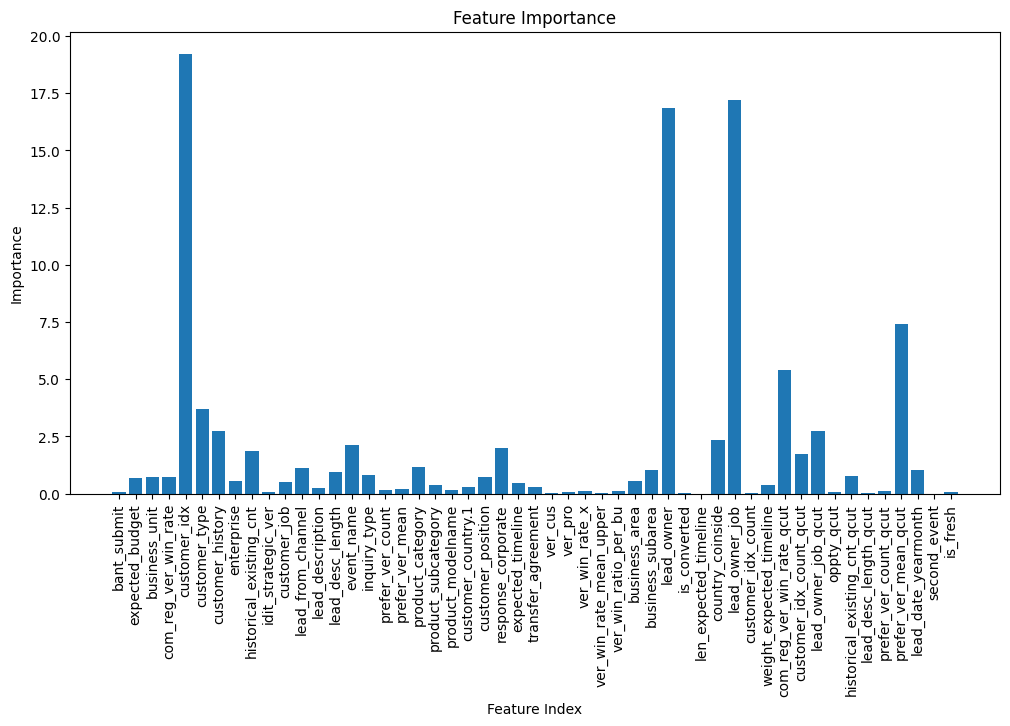

Learning rate set to 0.026101
0:	learn: 0.6565055	test: 0.6551447	best: 0.6551447 (0)	total: 22.3ms	remaining: 1m 51s
1:	learn: 0.6196474	test: 0.6177024	best: 0.6177024 (1)	total: 41ms	remaining: 1m 42s
2:	learn: 0.5880329	test: 0.5852534	best: 0.5852534 (2)	total: 61ms	remaining: 1m 41s
3:	learn: 0.5523018	test: 0.5478771	best: 0.5478771 (3)	total: 79.2ms	remaining: 1m 38s
4:	learn: 0.5249118	test: 0.5192584	best: 0.5192584 (4)	total: 97.8ms	remaining: 1m 37s
5:	learn: 0.5014748	test: 0.4952275	best: 0.4952275 (5)	total: 119ms	remaining: 1m 38s
6:	learn: 0.4798494	test: 0.4730056	best: 0.4730056 (6)	total: 141ms	remaining: 1m 40s
7:	learn: 0.4589814	test: 0.4514746	best: 0.4514746 (7)	total: 162ms	remaining: 1m 40s
8:	learn: 0.4407944	test: 0.4324662	best: 0.4324662 (8)	total: 180ms	remaining: 1m 39s
9:	learn: 0.4195338	test: 0.4106004	best: 0.4106004 (9)	total: 196ms	remaining: 1m 37s
10:	learn: 0.4033675	test: 0.3941735	best: 0.3941735 (10)	total: 215ms	remaining: 1m 37s
11:	learn:

93:	learn: 0.1641544	test: 0.1437336	best: 0.1437336 (93)	total: 1.89s	remaining: 1m 38s
94:	learn: 0.1638482	test: 0.1435874	best: 0.1435874 (94)	total: 1.91s	remaining: 1m 38s
95:	learn: 0.1636217	test: 0.1434681	best: 0.1434681 (95)	total: 1.93s	remaining: 1m 38s
96:	learn: 0.1633164	test: 0.1431958	best: 0.1431958 (96)	total: 1.95s	remaining: 1m 38s
97:	learn: 0.1628746	test: 0.1429432	best: 0.1429432 (97)	total: 1.97s	remaining: 1m 38s
98:	learn: 0.1619340	test: 0.1420248	best: 0.1420248 (98)	total: 1.98s	remaining: 1m 38s
99:	learn: 0.1616464	test: 0.1418088	best: 0.1418088 (99)	total: 2s	remaining: 1m 38s
100:	learn: 0.1612676	test: 0.1414577	best: 0.1414577 (100)	total: 2.02s	remaining: 1m 38s
101:	learn: 0.1610217	test: 0.1413699	best: 0.1413699 (101)	total: 2.04s	remaining: 1m 38s
102:	learn: 0.1607786	test: 0.1413345	best: 0.1413345 (102)	total: 2.06s	remaining: 1m 37s
103:	learn: 0.1604824	test: 0.1411988	best: 0.1411988 (103)	total: 2.08s	remaining: 1m 37s
104:	learn: 0.16

188:	learn: 0.1411211	test: 0.1295491	best: 0.1295491 (188)	total: 3.78s	remaining: 1m 36s
189:	learn: 0.1408388	test: 0.1294214	best: 0.1294214 (189)	total: 3.8s	remaining: 1m 36s
190:	learn: 0.1407445	test: 0.1294041	best: 0.1294041 (190)	total: 3.82s	remaining: 1m 36s
191:	learn: 0.1404105	test: 0.1292485	best: 0.1292485 (191)	total: 3.84s	remaining: 1m 36s
192:	learn: 0.1403003	test: 0.1291794	best: 0.1291794 (192)	total: 3.86s	remaining: 1m 36s
193:	learn: 0.1398470	test: 0.1287378	best: 0.1287378 (193)	total: 3.88s	remaining: 1m 36s
194:	learn: 0.1397259	test: 0.1286991	best: 0.1286991 (194)	total: 3.9s	remaining: 1m 36s
195:	learn: 0.1396025	test: 0.1286967	best: 0.1286967 (195)	total: 3.92s	remaining: 1m 35s
196:	learn: 0.1394971	test: 0.1286641	best: 0.1286641 (196)	total: 3.93s	remaining: 1m 35s
197:	learn: 0.1393315	test: 0.1285973	best: 0.1285973 (197)	total: 3.95s	remaining: 1m 35s
198:	learn: 0.1391686	test: 0.1285209	best: 0.1285209 (198)	total: 3.97s	remaining: 1m 35s
1

287:	learn: 0.1278063	test: 0.1243978	best: 0.1243758 (286)	total: 5.76s	remaining: 1m 34s
288:	learn: 0.1275819	test: 0.1243037	best: 0.1243037 (288)	total: 5.78s	remaining: 1m 34s
289:	learn: 0.1274218	test: 0.1242469	best: 0.1242469 (289)	total: 5.81s	remaining: 1m 34s
290:	learn: 0.1272498	test: 0.1241539	best: 0.1241539 (290)	total: 5.83s	remaining: 1m 34s
291:	learn: 0.1271412	test: 0.1241428	best: 0.1241428 (291)	total: 5.85s	remaining: 1m 34s
292:	learn: 0.1270177	test: 0.1241308	best: 0.1241308 (292)	total: 5.87s	remaining: 1m 34s
293:	learn: 0.1268811	test: 0.1241311	best: 0.1241308 (292)	total: 5.89s	remaining: 1m 34s
294:	learn: 0.1267629	test: 0.1241195	best: 0.1241195 (294)	total: 5.92s	remaining: 1m 34s
295:	learn: 0.1266764	test: 0.1241030	best: 0.1241030 (295)	total: 5.93s	remaining: 1m 34s
296:	learn: 0.1264794	test: 0.1239261	best: 0.1239261 (296)	total: 5.96s	remaining: 1m 34s
297:	learn: 0.1264351	test: 0.1239093	best: 0.1239093 (297)	total: 5.98s	remaining: 1m 34s

380:	learn: 0.1181502	test: 0.1214603	best: 0.1214432 (378)	total: 7.68s	remaining: 1m 33s
381:	learn: 0.1180013	test: 0.1214327	best: 0.1214327 (381)	total: 7.7s	remaining: 1m 33s
382:	learn: 0.1178827	test: 0.1213735	best: 0.1213735 (382)	total: 7.72s	remaining: 1m 33s
383:	learn: 0.1178022	test: 0.1213448	best: 0.1213448 (383)	total: 7.74s	remaining: 1m 33s
384:	learn: 0.1177589	test: 0.1213356	best: 0.1213356 (384)	total: 7.76s	remaining: 1m 33s
385:	learn: 0.1176571	test: 0.1213172	best: 0.1213172 (385)	total: 7.78s	remaining: 1m 33s
386:	learn: 0.1175273	test: 0.1212990	best: 0.1212990 (386)	total: 7.8s	remaining: 1m 33s
387:	learn: 0.1174245	test: 0.1212652	best: 0.1212652 (387)	total: 7.82s	remaining: 1m 32s
388:	learn: 0.1173255	test: 0.1211470	best: 0.1211470 (388)	total: 7.84s	remaining: 1m 33s
389:	learn: 0.1172807	test: 0.1211535	best: 0.1211470 (388)	total: 7.86s	remaining: 1m 32s
390:	learn: 0.1170897	test: 0.1211593	best: 0.1211470 (388)	total: 7.88s	remaining: 1m 32s
3

474:	learn: 0.1109592	test: 0.1194677	best: 0.1194677 (474)	total: 9.56s	remaining: 1m 31s
475:	learn: 0.1108312	test: 0.1194428	best: 0.1194428 (475)	total: 9.58s	remaining: 1m 31s
476:	learn: 0.1108043	test: 0.1194398	best: 0.1194398 (476)	total: 9.6s	remaining: 1m 31s
477:	learn: 0.1106369	test: 0.1193870	best: 0.1193870 (477)	total: 9.62s	remaining: 1m 30s
478:	learn: 0.1105756	test: 0.1193610	best: 0.1193610 (478)	total: 9.64s	remaining: 1m 30s
479:	learn: 0.1104736	test: 0.1193765	best: 0.1193610 (478)	total: 9.65s	remaining: 1m 30s
480:	learn: 0.1104243	test: 0.1193472	best: 0.1193472 (480)	total: 9.67s	remaining: 1m 30s
481:	learn: 0.1103944	test: 0.1193227	best: 0.1193227 (481)	total: 9.69s	remaining: 1m 30s
482:	learn: 0.1102266	test: 0.1191210	best: 0.1191210 (482)	total: 9.71s	remaining: 1m 30s
483:	learn: 0.1101686	test: 0.1191123	best: 0.1191123 (483)	total: 9.73s	remaining: 1m 30s
484:	learn: 0.1100981	test: 0.1191039	best: 0.1191039 (484)	total: 9.75s	remaining: 1m 30s


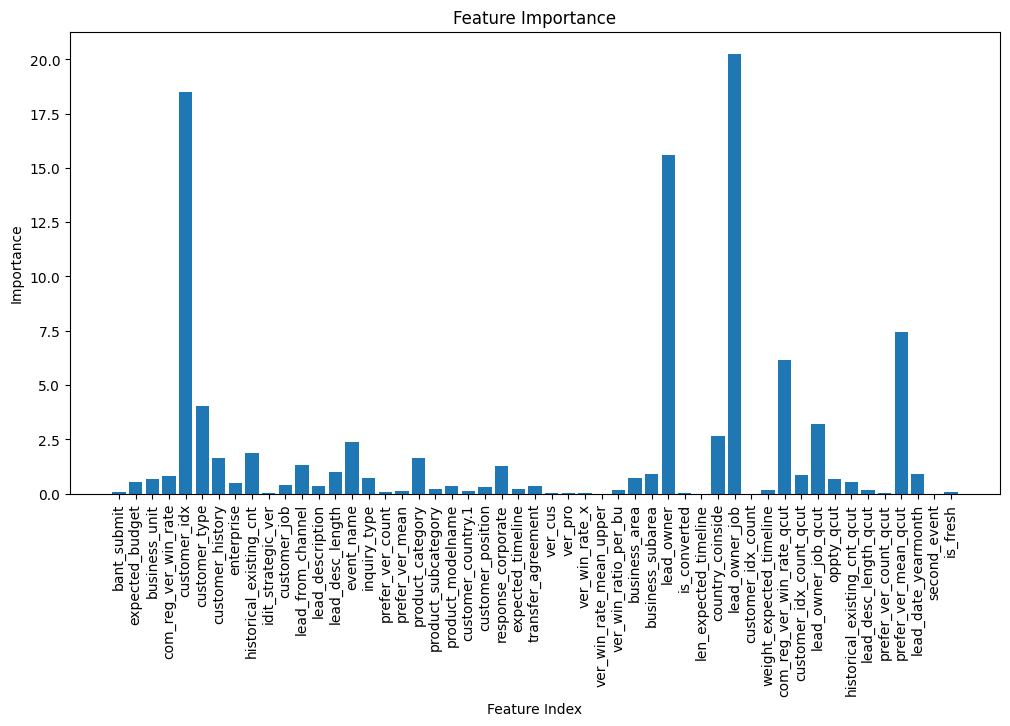

Learning rate set to 0.026101
0:	learn: 0.6550146	test: 0.6530653	best: 0.6530653 (0)	total: 24.1ms	remaining: 2m
1:	learn: 0.6269449	test: 0.6235618	best: 0.6235618 (1)	total: 45.2ms	remaining: 1m 52s
2:	learn: 0.5926535	test: 0.5863823	best: 0.5863823 (2)	total: 63.5ms	remaining: 1m 45s
3:	learn: 0.5568847	test: 0.5500854	best: 0.5500854 (3)	total: 82.2ms	remaining: 1m 42s
4:	learn: 0.5293378	test: 0.5208469	best: 0.5208469 (4)	total: 103ms	remaining: 1m 43s
5:	learn: 0.5039397	test: 0.4939206	best: 0.4939206 (5)	total: 123ms	remaining: 1m 42s
6:	learn: 0.4841549	test: 0.4722719	best: 0.4722719 (6)	total: 144ms	remaining: 1m 43s
7:	learn: 0.4674147	test: 0.4546996	best: 0.4546996 (7)	total: 164ms	remaining: 1m 42s
8:	learn: 0.4449879	test: 0.4309206	best: 0.4309206 (8)	total: 182ms	remaining: 1m 40s
9:	learn: 0.4290171	test: 0.4146629	best: 0.4146629 (9)	total: 202ms	remaining: 1m 40s
10:	learn: 0.4123229	test: 0.3973482	best: 0.3973482 (10)	total: 218ms	remaining: 1m 38s
11:	learn: 

93:	learn: 0.1555874	test: 0.1420769	best: 0.1420769 (93)	total: 1.89s	remaining: 1m 38s
94:	learn: 0.1551844	test: 0.1417092	best: 0.1417092 (94)	total: 1.91s	remaining: 1m 38s
95:	learn: 0.1549169	test: 0.1415803	best: 0.1415803 (95)	total: 1.93s	remaining: 1m 38s
96:	learn: 0.1545598	test: 0.1414910	best: 0.1414910 (96)	total: 1.95s	remaining: 1m 38s
97:	learn: 0.1542183	test: 0.1412450	best: 0.1412450 (97)	total: 1.97s	remaining: 1m 38s
98:	learn: 0.1537238	test: 0.1409089	best: 0.1409089 (98)	total: 1.99s	remaining: 1m 38s
99:	learn: 0.1535674	test: 0.1408703	best: 0.1408703 (99)	total: 2.01s	remaining: 1m 38s
100:	learn: 0.1532375	test: 0.1406982	best: 0.1406982 (100)	total: 2.03s	remaining: 1m 38s
101:	learn: 0.1530242	test: 0.1406167	best: 0.1406167 (101)	total: 2.05s	remaining: 1m 38s
102:	learn: 0.1527493	test: 0.1404380	best: 0.1404380 (102)	total: 2.07s	remaining: 1m 38s
103:	learn: 0.1525596	test: 0.1403151	best: 0.1403151 (103)	total: 2.08s	remaining: 1m 38s
104:	learn: 0

187:	learn: 0.1349905	test: 0.1309556	best: 0.1309556 (187)	total: 3.77s	remaining: 1m 36s
188:	learn: 0.1349899	test: 0.1309537	best: 0.1309537 (188)	total: 3.78s	remaining: 1m 36s
189:	learn: 0.1348669	test: 0.1308816	best: 0.1308816 (189)	total: 3.8s	remaining: 1m 36s
190:	learn: 0.1348171	test: 0.1308760	best: 0.1308760 (190)	total: 3.82s	remaining: 1m 36s
191:	learn: 0.1346749	test: 0.1308907	best: 0.1308760 (190)	total: 3.83s	remaining: 1m 36s
192:	learn: 0.1345455	test: 0.1308024	best: 0.1308024 (192)	total: 3.85s	remaining: 1m 36s
193:	learn: 0.1344402	test: 0.1306808	best: 0.1306808 (193)	total: 3.88s	remaining: 1m 36s
194:	learn: 0.1343450	test: 0.1306808	best: 0.1306808 (193)	total: 3.89s	remaining: 1m 35s
195:	learn: 0.1342672	test: 0.1306799	best: 0.1306799 (195)	total: 3.91s	remaining: 1m 35s
196:	learn: 0.1341403	test: 0.1305783	best: 0.1305783 (196)	total: 3.93s	remaining: 1m 35s
197:	learn: 0.1339470	test: 0.1305330	best: 0.1305330 (197)	total: 3.95s	remaining: 1m 35s


284:	learn: 0.1248732	test: 0.1270462	best: 0.1270462 (284)	total: 5.64s	remaining: 1m 33s
285:	learn: 0.1246322	test: 0.1270038	best: 0.1270038 (285)	total: 5.66s	remaining: 1m 33s
286:	learn: 0.1245525	test: 0.1270154	best: 0.1270038 (285)	total: 5.68s	remaining: 1m 33s
287:	learn: 0.1244874	test: 0.1269948	best: 0.1269948 (287)	total: 5.7s	remaining: 1m 33s
288:	learn: 0.1243643	test: 0.1269113	best: 0.1269113 (288)	total: 5.72s	remaining: 1m 33s
289:	learn: 0.1243234	test: 0.1269080	best: 0.1269080 (289)	total: 5.74s	remaining: 1m 33s
290:	learn: 0.1241745	test: 0.1268053	best: 0.1268053 (290)	total: 5.76s	remaining: 1m 33s
291:	learn: 0.1241225	test: 0.1267862	best: 0.1267862 (291)	total: 5.78s	remaining: 1m 33s
292:	learn: 0.1240536	test: 0.1268303	best: 0.1267862 (291)	total: 5.8s	remaining: 1m 33s
293:	learn: 0.1239750	test: 0.1268185	best: 0.1267862 (291)	total: 5.82s	remaining: 1m 33s
294:	learn: 0.1238921	test: 0.1267748	best: 0.1267748 (294)	total: 5.84s	remaining: 1m 33s
2

381:	learn: 0.1167256	test: 0.1240848	best: 0.1240848 (381)	total: 7.56s	remaining: 1m 31s
382:	learn: 0.1166421	test: 0.1240800	best: 0.1240800 (382)	total: 7.58s	remaining: 1m 31s
383:	learn: 0.1165851	test: 0.1240452	best: 0.1240452 (383)	total: 7.61s	remaining: 1m 31s
384:	learn: 0.1165384	test: 0.1240131	best: 0.1240131 (384)	total: 7.63s	remaining: 1m 31s
385:	learn: 0.1164960	test: 0.1240456	best: 0.1240131 (384)	total: 7.66s	remaining: 1m 31s
386:	learn: 0.1164342	test: 0.1240779	best: 0.1240131 (384)	total: 7.68s	remaining: 1m 31s
387:	learn: 0.1162174	test: 0.1241085	best: 0.1240131 (384)	total: 7.7s	remaining: 1m 31s
388:	learn: 0.1161103	test: 0.1240648	best: 0.1240131 (384)	total: 7.73s	remaining: 1m 31s
389:	learn: 0.1160601	test: 0.1240144	best: 0.1240131 (384)	total: 7.75s	remaining: 1m 31s
390:	learn: 0.1160301	test: 0.1240004	best: 0.1240004 (390)	total: 7.77s	remaining: 1m 31s
391:	learn: 0.1159885	test: 0.1239859	best: 0.1239859 (391)	total: 7.79s	remaining: 1m 31s


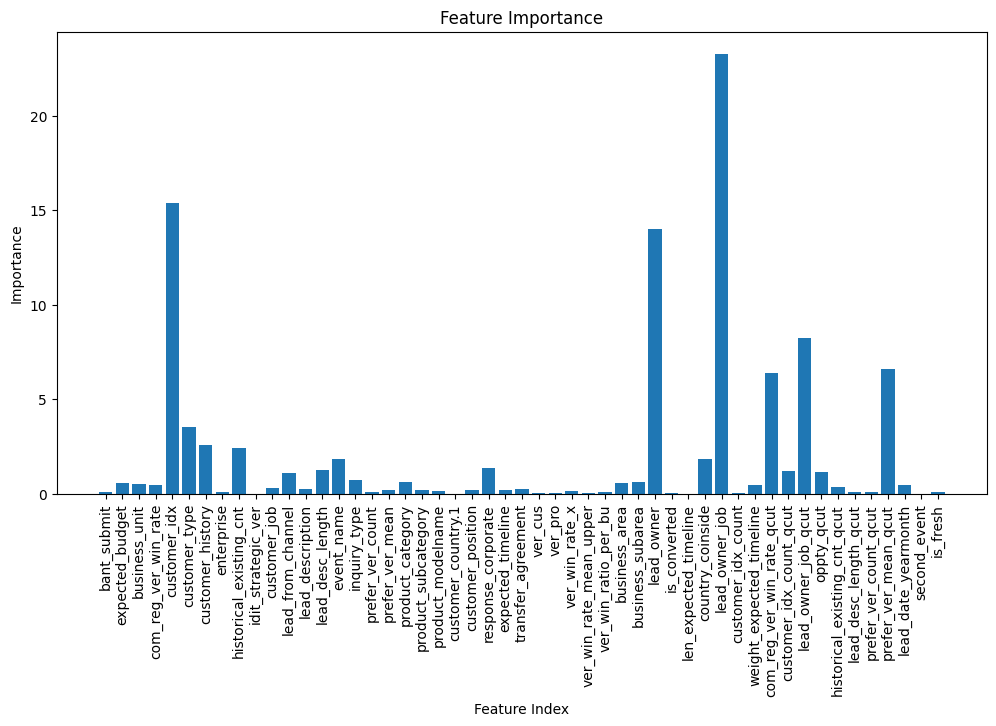

Learning rate set to 0.026101
0:	learn: 0.6483612	test: 0.6482514	best: 0.6482514 (0)	total: 23.1ms	remaining: 1m 55s
1:	learn: 0.6152656	test: 0.6139460	best: 0.6139460 (1)	total: 42.1ms	remaining: 1m 45s
2:	learn: 0.5825953	test: 0.5817509	best: 0.5817509 (2)	total: 64.1ms	remaining: 1m 46s
3:	learn: 0.5440182	test: 0.5426641	best: 0.5426641 (3)	total: 82.4ms	remaining: 1m 42s
4:	learn: 0.5173430	test: 0.5158282	best: 0.5158282 (4)	total: 103ms	remaining: 1m 43s
5:	learn: 0.4918861	test: 0.4903391	best: 0.4903391 (5)	total: 122ms	remaining: 1m 41s
6:	learn: 0.4669179	test: 0.4651800	best: 0.4651800 (6)	total: 139ms	remaining: 1m 39s
7:	learn: 0.4464774	test: 0.4447360	best: 0.4447360 (7)	total: 159ms	remaining: 1m 39s
8:	learn: 0.4236908	test: 0.4219806	best: 0.4219806 (8)	total: 176ms	remaining: 1m 37s
9:	learn: 0.4077514	test: 0.4059079	best: 0.4059079 (9)	total: 193ms	remaining: 1m 36s
10:	learn: 0.3918803	test: 0.3900752	best: 0.3900752 (10)	total: 213ms	remaining: 1m 36s
11:	lea

95:	learn: 0.1548205	test: 0.1560445	best: 0.1560445 (95)	total: 1.89s	remaining: 1m 36s
96:	learn: 0.1544803	test: 0.1558284	best: 0.1558284 (96)	total: 1.91s	remaining: 1m 36s
97:	learn: 0.1540521	test: 0.1555751	best: 0.1555751 (97)	total: 1.93s	remaining: 1m 36s
98:	learn: 0.1537869	test: 0.1554187	best: 0.1554187 (98)	total: 1.95s	remaining: 1m 36s
99:	learn: 0.1534309	test: 0.1553588	best: 0.1553588 (99)	total: 1.96s	remaining: 1m 36s
100:	learn: 0.1530579	test: 0.1551869	best: 0.1551869 (100)	total: 1.98s	remaining: 1m 36s
101:	learn: 0.1528427	test: 0.1550457	best: 0.1550457 (101)	total: 2s	remaining: 1m 36s
102:	learn: 0.1525615	test: 0.1548403	best: 0.1548403 (102)	total: 2.02s	remaining: 1m 35s
103:	learn: 0.1521240	test: 0.1543874	best: 0.1543874 (103)	total: 2.04s	remaining: 1m 35s
104:	learn: 0.1518617	test: 0.1542803	best: 0.1542803 (104)	total: 2.06s	remaining: 1m 35s
105:	learn: 0.1516394	test: 0.1541197	best: 0.1541197 (105)	total: 2.07s	remaining: 1m 35s
106:	learn: 

192:	learn: 0.1335688	test: 0.1422528	best: 0.1422497 (191)	total: 3.8s	remaining: 1m 34s
193:	learn: 0.1333480	test: 0.1420380	best: 0.1420380 (193)	total: 3.81s	remaining: 1m 34s
194:	learn: 0.1332097	test: 0.1420287	best: 0.1420287 (194)	total: 3.83s	remaining: 1m 34s
195:	learn: 0.1329499	test: 0.1419025	best: 0.1419025 (195)	total: 3.85s	remaining: 1m 34s
196:	learn: 0.1328230	test: 0.1418256	best: 0.1418256 (196)	total: 3.87s	remaining: 1m 34s
197:	learn: 0.1326493	test: 0.1416869	best: 0.1416869 (197)	total: 3.89s	remaining: 1m 34s
198:	learn: 0.1326096	test: 0.1416402	best: 0.1416402 (198)	total: 3.91s	remaining: 1m 34s
199:	learn: 0.1324519	test: 0.1415502	best: 0.1415502 (199)	total: 3.93s	remaining: 1m 34s
200:	learn: 0.1322908	test: 0.1415070	best: 0.1415070 (200)	total: 3.95s	remaining: 1m 34s
201:	learn: 0.1321267	test: 0.1414454	best: 0.1414454 (201)	total: 3.98s	remaining: 1m 34s
202:	learn: 0.1319571	test: 0.1413380	best: 0.1413380 (202)	total: 4s	remaining: 1m 34s
203

288:	learn: 0.1217417	test: 0.1358691	best: 0.1358691 (288)	total: 5.68s	remaining: 1m 32s
289:	learn: 0.1216822	test: 0.1359457	best: 0.1358691 (288)	total: 5.7s	remaining: 1m 32s
290:	learn: 0.1215080	test: 0.1357850	best: 0.1357850 (290)	total: 5.72s	remaining: 1m 32s
291:	learn: 0.1215080	test: 0.1357850	best: 0.1357850 (291)	total: 5.73s	remaining: 1m 32s
292:	learn: 0.1213395	test: 0.1357366	best: 0.1357366 (292)	total: 5.75s	remaining: 1m 32s
293:	learn: 0.1212496	test: 0.1357118	best: 0.1357118 (293)	total: 5.78s	remaining: 1m 32s
294:	learn: 0.1211199	test: 0.1357093	best: 0.1357093 (294)	total: 5.8s	remaining: 1m 32s
295:	learn: 0.1210329	test: 0.1356639	best: 0.1356639 (295)	total: 5.82s	remaining: 1m 32s
296:	learn: 0.1208599	test: 0.1355242	best: 0.1355242 (296)	total: 5.85s	remaining: 1m 32s
297:	learn: 0.1207714	test: 0.1354076	best: 0.1354076 (297)	total: 5.87s	remaining: 1m 32s
298:	learn: 0.1207070	test: 0.1353228	best: 0.1353228 (298)	total: 5.89s	remaining: 1m 32s
2

385:	learn: 0.1130118	test: 0.1329816	best: 0.1329816 (385)	total: 7.6s	remaining: 1m 30s
386:	learn: 0.1129446	test: 0.1329688	best: 0.1329688 (386)	total: 7.62s	remaining: 1m 30s
387:	learn: 0.1128592	test: 0.1329107	best: 0.1329107 (387)	total: 7.64s	remaining: 1m 30s
388:	learn: 0.1127102	test: 0.1329401	best: 0.1329107 (387)	total: 7.67s	remaining: 1m 30s
389:	learn: 0.1126325	test: 0.1328413	best: 0.1328413 (389)	total: 7.68s	remaining: 1m 30s
390:	learn: 0.1125618	test: 0.1328149	best: 0.1328149 (390)	total: 7.71s	remaining: 1m 30s
391:	learn: 0.1125447	test: 0.1328153	best: 0.1328149 (390)	total: 7.72s	remaining: 1m 30s
392:	learn: 0.1124558	test: 0.1327714	best: 0.1327714 (392)	total: 7.74s	remaining: 1m 30s
393:	learn: 0.1124327	test: 0.1327088	best: 0.1327088 (393)	total: 7.76s	remaining: 1m 30s
394:	learn: 0.1123379	test: 0.1326305	best: 0.1326305 (394)	total: 7.78s	remaining: 1m 30s
395:	learn: 0.1122616	test: 0.1326220	best: 0.1326220 (395)	total: 7.8s	remaining: 1m 30s
3

478:	learn: 0.1056163	test: 0.1301183	best: 0.1301183 (478)	total: 9.51s	remaining: 1m 29s
479:	learn: 0.1055550	test: 0.1301252	best: 0.1301183 (478)	total: 9.53s	remaining: 1m 29s
480:	learn: 0.1055114	test: 0.1300967	best: 0.1300967 (480)	total: 9.55s	remaining: 1m 29s
481:	learn: 0.1054059	test: 0.1300392	best: 0.1300392 (481)	total: 9.57s	remaining: 1m 29s
482:	learn: 0.1053511	test: 0.1300539	best: 0.1300392 (481)	total: 9.59s	remaining: 1m 29s
483:	learn: 0.1052939	test: 0.1300349	best: 0.1300349 (483)	total: 9.61s	remaining: 1m 29s
484:	learn: 0.1051692	test: 0.1299939	best: 0.1299939 (484)	total: 9.63s	remaining: 1m 29s
485:	learn: 0.1050741	test: 0.1299496	best: 0.1299496 (485)	total: 9.65s	remaining: 1m 29s
486:	learn: 0.1050239	test: 0.1299288	best: 0.1299288 (486)	total: 9.67s	remaining: 1m 29s
487:	learn: 0.1049715	test: 0.1298818	best: 0.1298818 (487)	total: 9.69s	remaining: 1m 29s
488:	learn: 0.1048502	test: 0.1297909	best: 0.1297909 (488)	total: 9.71s	remaining: 1m 29s

572:	learn: 0.0995492	test: 0.1279108	best: 0.1279108 (572)	total: 11.4s	remaining: 1m 28s
573:	learn: 0.0995281	test: 0.1279064	best: 0.1279064 (573)	total: 11.4s	remaining: 1m 28s
574:	learn: 0.0995163	test: 0.1278983	best: 0.1278983 (574)	total: 11.5s	remaining: 1m 28s
575:	learn: 0.0994625	test: 0.1279094	best: 0.1278983 (574)	total: 11.5s	remaining: 1m 28s
576:	learn: 0.0994119	test: 0.1278637	best: 0.1278637 (576)	total: 11.5s	remaining: 1m 28s
577:	learn: 0.0993801	test: 0.1278805	best: 0.1278637 (576)	total: 11.5s	remaining: 1m 28s
578:	learn: 0.0993528	test: 0.1278655	best: 0.1278637 (576)	total: 11.5s	remaining: 1m 28s
579:	learn: 0.0992932	test: 0.1278331	best: 0.1278331 (579)	total: 11.6s	remaining: 1m 28s
580:	learn: 0.0991725	test: 0.1277605	best: 0.1277605 (580)	total: 11.6s	remaining: 1m 28s
581:	learn: 0.0991422	test: 0.1277309	best: 0.1277309 (581)	total: 11.6s	remaining: 1m 28s
582:	learn: 0.0991162	test: 0.1277141	best: 0.1277141 (582)	total: 11.6s	remaining: 1m 28s

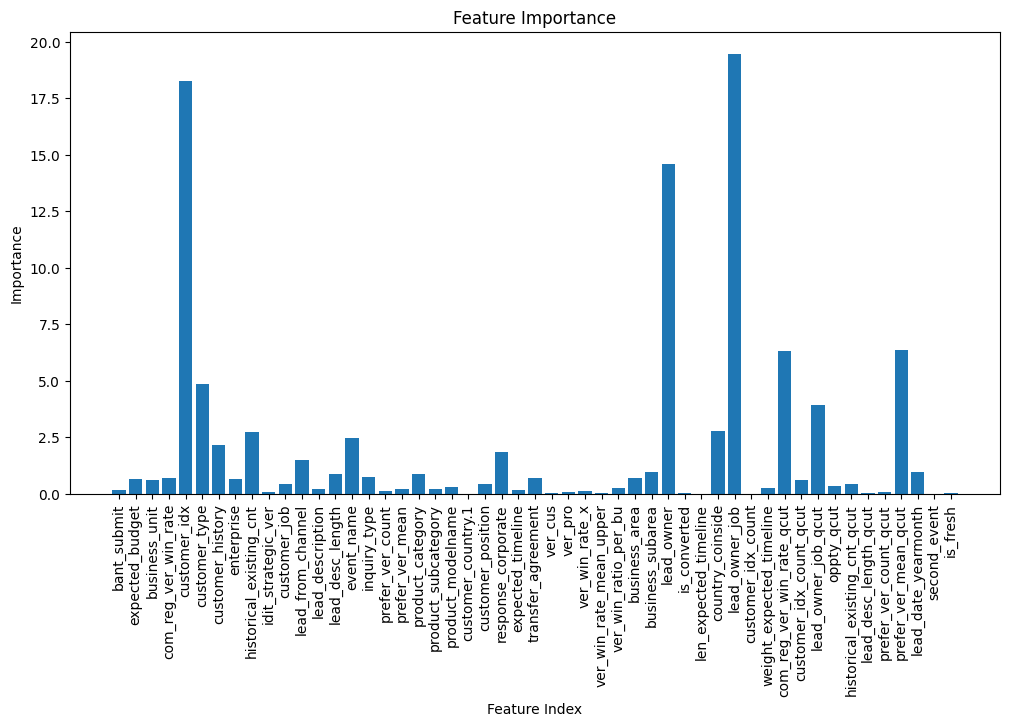

Learning rate set to 0.026101
0:	learn: 0.6508033	test: 0.6491019	best: 0.6491019 (0)	total: 26.9ms	remaining: 2m 14s
1:	learn: 0.6128270	test: 0.6102795	best: 0.6102795 (1)	total: 46.5ms	remaining: 1m 56s
2:	learn: 0.5799983	test: 0.5768076	best: 0.5768076 (2)	total: 64.4ms	remaining: 1m 47s
3:	learn: 0.5514824	test: 0.5476566	best: 0.5476566 (3)	total: 87.1ms	remaining: 1m 48s
4:	learn: 0.5254600	test: 0.5205970	best: 0.5205970 (4)	total: 106ms	remaining: 1m 46s
5:	learn: 0.5016040	test: 0.4968750	best: 0.4968750 (5)	total: 125ms	remaining: 1m 44s
6:	learn: 0.4779517	test: 0.4719993	best: 0.4719993 (6)	total: 144ms	remaining: 1m 42s
7:	learn: 0.4526169	test: 0.4465760	best: 0.4465760 (7)	total: 165ms	remaining: 1m 43s
8:	learn: 0.4358752	test: 0.4294914	best: 0.4294914 (8)	total: 184ms	remaining: 1m 41s
9:	learn: 0.4166147	test: 0.4100186	best: 0.4100186 (9)	total: 207ms	remaining: 1m 43s
10:	learn: 0.3960090	test: 0.3891915	best: 0.3891915 (10)	total: 225ms	remaining: 1m 42s
11:	lea

96:	learn: 0.1581025	test: 0.1536897	best: 0.1536897 (96)	total: 1.92s	remaining: 1m 37s
97:	learn: 0.1577647	test: 0.1535375	best: 0.1535375 (97)	total: 1.94s	remaining: 1m 37s
98:	learn: 0.1575169	test: 0.1534037	best: 0.1534037 (98)	total: 1.96s	remaining: 1m 37s
99:	learn: 0.1569156	test: 0.1528246	best: 0.1528246 (99)	total: 1.98s	remaining: 1m 36s
100:	learn: 0.1566955	test: 0.1525472	best: 0.1525472 (100)	total: 2s	remaining: 1m 37s
101:	learn: 0.1565055	test: 0.1525903	best: 0.1525472 (100)	total: 2.02s	remaining: 1m 37s
102:	learn: 0.1561834	test: 0.1523974	best: 0.1523974 (102)	total: 2.04s	remaining: 1m 37s
103:	learn: 0.1558671	test: 0.1522991	best: 0.1522991 (103)	total: 2.06s	remaining: 1m 37s
104:	learn: 0.1555590	test: 0.1520427	best: 0.1520427 (104)	total: 2.08s	remaining: 1m 37s
105:	learn: 0.1552654	test: 0.1518822	best: 0.1518822 (105)	total: 2.1s	remaining: 1m 37s
106:	learn: 0.1549823	test: 0.1515778	best: 0.1515778 (106)	total: 2.13s	remaining: 1m 37s
107:	learn:

192:	learn: 0.1373975	test: 0.1415285	best: 0.1415011 (191)	total: 3.82s	remaining: 1m 35s
193:	learn: 0.1373061	test: 0.1414830	best: 0.1414830 (193)	total: 3.83s	remaining: 1m 34s
194:	learn: 0.1369609	test: 0.1413573	best: 0.1413573 (194)	total: 3.85s	remaining: 1m 34s
195:	learn: 0.1367330	test: 0.1412931	best: 0.1412931 (195)	total: 3.87s	remaining: 1m 34s
196:	learn: 0.1365540	test: 0.1412442	best: 0.1412442 (196)	total: 3.89s	remaining: 1m 34s
197:	learn: 0.1363314	test: 0.1411175	best: 0.1411175 (197)	total: 3.91s	remaining: 1m 34s
198:	learn: 0.1362168	test: 0.1411459	best: 0.1411175 (197)	total: 3.93s	remaining: 1m 34s
199:	learn: 0.1359980	test: 0.1410467	best: 0.1410467 (199)	total: 3.95s	remaining: 1m 34s
200:	learn: 0.1358605	test: 0.1409848	best: 0.1409848 (200)	total: 3.97s	remaining: 1m 34s
201:	learn: 0.1357509	test: 0.1409676	best: 0.1409676 (201)	total: 3.98s	remaining: 1m 34s
202:	learn: 0.1355969	test: 0.1407987	best: 0.1407987 (202)	total: 4s	remaining: 1m 34s
20

287:	learn: 0.1253921	test: 0.1360347	best: 0.1360347 (287)	total: 5.68s	remaining: 1m 32s
288:	learn: 0.1253035	test: 0.1359876	best: 0.1359876 (288)	total: 5.7s	remaining: 1m 32s
289:	learn: 0.1253021	test: 0.1359831	best: 0.1359831 (289)	total: 5.72s	remaining: 1m 32s
290:	learn: 0.1252291	test: 0.1359585	best: 0.1359585 (290)	total: 5.74s	remaining: 1m 32s
291:	learn: 0.1251366	test: 0.1359965	best: 0.1359585 (290)	total: 5.75s	remaining: 1m 32s
292:	learn: 0.1248833	test: 0.1358436	best: 0.1358436 (292)	total: 5.78s	remaining: 1m 32s
293:	learn: 0.1246985	test: 0.1357445	best: 0.1357445 (293)	total: 5.79s	remaining: 1m 32s
294:	learn: 0.1246034	test: 0.1357240	best: 0.1357240 (294)	total: 5.82s	remaining: 1m 32s
295:	learn: 0.1245334	test: 0.1356835	best: 0.1356835 (295)	total: 5.84s	remaining: 1m 32s
296:	learn: 0.1244848	test: 0.1356521	best: 0.1356521 (296)	total: 5.86s	remaining: 1m 32s
297:	learn: 0.1244238	test: 0.1356154	best: 0.1356154 (297)	total: 5.88s	remaining: 1m 32s


382:	learn: 0.1165635	test: 0.1326206	best: 0.1326148 (379)	total: 7.58s	remaining: 1m 31s
383:	learn: 0.1165094	test: 0.1326130	best: 0.1326130 (383)	total: 7.61s	remaining: 1m 31s
384:	learn: 0.1165011	test: 0.1326240	best: 0.1326130 (383)	total: 7.63s	remaining: 1m 31s
385:	learn: 0.1164991	test: 0.1326166	best: 0.1326130 (383)	total: 7.65s	remaining: 1m 31s
386:	learn: 0.1163310	test: 0.1325358	best: 0.1325358 (386)	total: 7.67s	remaining: 1m 31s
387:	learn: 0.1163212	test: 0.1325186	best: 0.1325186 (387)	total: 7.69s	remaining: 1m 31s
388:	learn: 0.1160978	test: 0.1323922	best: 0.1323922 (388)	total: 7.71s	remaining: 1m 31s
389:	learn: 0.1160436	test: 0.1323459	best: 0.1323459 (389)	total: 7.74s	remaining: 1m 31s
390:	learn: 0.1159649	test: 0.1323618	best: 0.1323459 (389)	total: 7.76s	remaining: 1m 31s
391:	learn: 0.1159612	test: 0.1323529	best: 0.1323459 (389)	total: 7.78s	remaining: 1m 31s
392:	learn: 0.1159606	test: 0.1323553	best: 0.1323459 (389)	total: 7.8s	remaining: 1m 31s


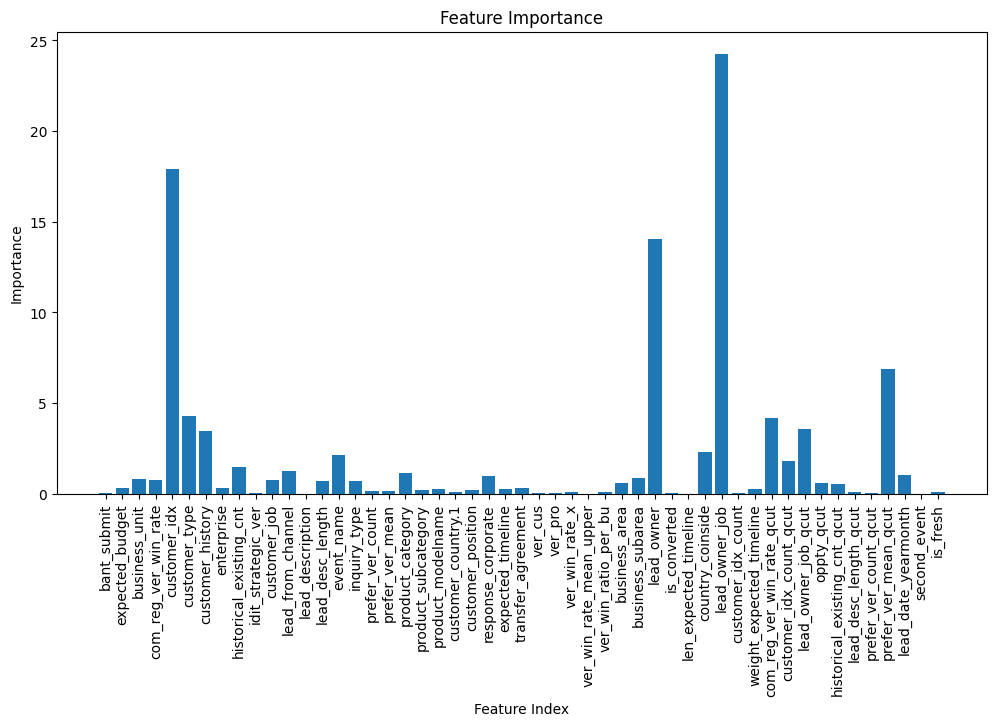

Learning rate set to 0.026101
0:	learn: 0.6512614	test: 0.6500384	best: 0.6500384 (0)	total: 23.7ms	remaining: 1m 58s
1:	learn: 0.6120921	test: 0.6089019	best: 0.6089019 (1)	total: 42.7ms	remaining: 1m 46s
2:	learn: 0.5807788	test: 0.5758424	best: 0.5758424 (2)	total: 60.3ms	remaining: 1m 40s
3:	learn: 0.5504063	test: 0.5447709	best: 0.5447709 (3)	total: 80.6ms	remaining: 1m 40s
4:	learn: 0.5198506	test: 0.5134364	best: 0.5134364 (4)	total: 101ms	remaining: 1m 40s
5:	learn: 0.4919513	test: 0.4848024	best: 0.4848024 (5)	total: 119ms	remaining: 1m 38s
6:	learn: 0.4711855	test: 0.4630281	best: 0.4630281 (6)	total: 140ms	remaining: 1m 40s
7:	learn: 0.4602633	test: 0.4519750	best: 0.4519750 (7)	total: 158ms	remaining: 1m 38s
8:	learn: 0.4426779	test: 0.4333011	best: 0.4333011 (8)	total: 176ms	remaining: 1m 37s
9:	learn: 0.4202404	test: 0.4109065	best: 0.4109065 (9)	total: 195ms	remaining: 1m 37s
10:	learn: 0.4040112	test: 0.3943913	best: 0.3943913 (10)	total: 218ms	remaining: 1m 38s
11:	lea

94:	learn: 0.1600696	test: 0.1459937	best: 0.1459937 (94)	total: 1.92s	remaining: 1m 38s
95:	learn: 0.1596321	test: 0.1455383	best: 0.1455383 (95)	total: 1.94s	remaining: 1m 38s
96:	learn: 0.1595024	test: 0.1454815	best: 0.1454815 (96)	total: 1.96s	remaining: 1m 39s
97:	learn: 0.1592262	test: 0.1453417	best: 0.1453417 (97)	total: 1.98s	remaining: 1m 39s
98:	learn: 0.1588082	test: 0.1449377	best: 0.1449377 (98)	total: 2s	remaining: 1m 39s
99:	learn: 0.1584041	test: 0.1445277	best: 0.1445277 (99)	total: 2.02s	remaining: 1m 39s
100:	learn: 0.1581650	test: 0.1442575	best: 0.1442575 (100)	total: 2.04s	remaining: 1m 39s
101:	learn: 0.1576229	test: 0.1435628	best: 0.1435628 (101)	total: 2.07s	remaining: 1m 39s
102:	learn: 0.1574096	test: 0.1433547	best: 0.1433547 (102)	total: 2.09s	remaining: 1m 39s
103:	learn: 0.1571741	test: 0.1431702	best: 0.1431702 (103)	total: 2.11s	remaining: 1m 39s
104:	learn: 0.1567719	test: 0.1428853	best: 0.1428853 (104)	total: 2.13s	remaining: 1m 39s
105:	learn: 0.

190:	learn: 0.1405893	test: 0.1309244	best: 0.1309244 (190)	total: 3.83s	remaining: 1m 36s
191:	learn: 0.1404943	test: 0.1308807	best: 0.1308807 (191)	total: 3.85s	remaining: 1m 36s
192:	learn: 0.1404045	test: 0.1308449	best: 0.1308449 (192)	total: 3.87s	remaining: 1m 36s
193:	learn: 0.1403693	test: 0.1308531	best: 0.1308449 (192)	total: 3.89s	remaining: 1m 36s
194:	learn: 0.1402312	test: 0.1307766	best: 0.1307766 (194)	total: 3.91s	remaining: 1m 36s
195:	learn: 0.1401067	test: 0.1307367	best: 0.1307367 (195)	total: 3.93s	remaining: 1m 36s
196:	learn: 0.1400334	test: 0.1307241	best: 0.1307241 (196)	total: 3.95s	remaining: 1m 36s
197:	learn: 0.1399604	test: 0.1307150	best: 0.1307150 (197)	total: 3.96s	remaining: 1m 36s
198:	learn: 0.1398354	test: 0.1305913	best: 0.1305913 (198)	total: 3.98s	remaining: 1m 36s
199:	learn: 0.1396505	test: 0.1306075	best: 0.1305913 (198)	total: 4s	remaining: 1m 36s
200:	learn: 0.1394801	test: 0.1305384	best: 0.1305384 (200)	total: 4.02s	remaining: 1m 36s
20

287:	learn: 0.1290074	test: 0.1238409	best: 0.1238409 (287)	total: 5.71s	remaining: 1m 33s
288:	learn: 0.1289870	test: 0.1238492	best: 0.1238409 (287)	total: 5.73s	remaining: 1m 33s
289:	learn: 0.1289196	test: 0.1238348	best: 0.1238348 (289)	total: 5.75s	remaining: 1m 33s
290:	learn: 0.1288653	test: 0.1238220	best: 0.1238220 (290)	total: 5.77s	remaining: 1m 33s
291:	learn: 0.1288117	test: 0.1238164	best: 0.1238164 (291)	total: 5.79s	remaining: 1m 33s
292:	learn: 0.1287742	test: 0.1237899	best: 0.1237899 (292)	total: 5.81s	remaining: 1m 33s
293:	learn: 0.1287125	test: 0.1237683	best: 0.1237683 (293)	total: 5.83s	remaining: 1m 33s
294:	learn: 0.1286594	test: 0.1237279	best: 0.1237279 (294)	total: 5.85s	remaining: 1m 33s
295:	learn: 0.1285950	test: 0.1237138	best: 0.1237138 (295)	total: 5.87s	remaining: 1m 33s
296:	learn: 0.1284943	test: 0.1236916	best: 0.1236916 (296)	total: 5.89s	remaining: 1m 33s
297:	learn: 0.1282868	test: 0.1235435	best: 0.1235435 (297)	total: 5.91s	remaining: 1m 33s

384:	learn: 0.1218453	test: 0.1208055	best: 0.1207897 (382)	total: 7.6s	remaining: 1m 31s
385:	learn: 0.1216694	test: 0.1206307	best: 0.1206307 (385)	total: 7.63s	remaining: 1m 31s
386:	learn: 0.1215684	test: 0.1206202	best: 0.1206202 (386)	total: 7.65s	remaining: 1m 31s
387:	learn: 0.1215680	test: 0.1206197	best: 0.1206197 (387)	total: 7.66s	remaining: 1m 31s
388:	learn: 0.1214551	test: 0.1205515	best: 0.1205515 (388)	total: 7.68s	remaining: 1m 31s
389:	learn: 0.1214248	test: 0.1205639	best: 0.1205515 (388)	total: 7.7s	remaining: 1m 31s
390:	learn: 0.1213421	test: 0.1205349	best: 0.1205349 (390)	total: 7.72s	remaining: 1m 31s
391:	learn: 0.1213279	test: 0.1205336	best: 0.1205336 (391)	total: 7.75s	remaining: 1m 31s
392:	learn: 0.1213275	test: 0.1205333	best: 0.1205333 (392)	total: 7.76s	remaining: 1m 30s
393:	learn: 0.1211851	test: 0.1204818	best: 0.1204818 (393)	total: 7.78s	remaining: 1m 30s
394:	learn: 0.1210438	test: 0.1204481	best: 0.1204481 (394)	total: 7.8s	remaining: 1m 30s
39

477:	learn: 0.1156635	test: 0.1176920	best: 0.1176920 (477)	total: 9.48s	remaining: 1m 29s
478:	learn: 0.1156023	test: 0.1176824	best: 0.1176824 (478)	total: 9.5s	remaining: 1m 29s
479:	learn: 0.1155483	test: 0.1176113	best: 0.1176113 (479)	total: 9.53s	remaining: 1m 29s
480:	learn: 0.1155464	test: 0.1176109	best: 0.1176109 (480)	total: 9.55s	remaining: 1m 29s
481:	learn: 0.1154905	test: 0.1175562	best: 0.1175562 (481)	total: 9.57s	remaining: 1m 29s
482:	learn: 0.1154494	test: 0.1175567	best: 0.1175562 (481)	total: 9.59s	remaining: 1m 29s
483:	learn: 0.1153366	test: 0.1175565	best: 0.1175562 (481)	total: 9.61s	remaining: 1m 29s
484:	learn: 0.1153110	test: 0.1175545	best: 0.1175545 (484)	total: 9.63s	remaining: 1m 29s
485:	learn: 0.1152220	test: 0.1174937	best: 0.1174937 (485)	total: 9.65s	remaining: 1m 29s
486:	learn: 0.1151742	test: 0.1174741	best: 0.1174741 (486)	total: 9.67s	remaining: 1m 29s
487:	learn: 0.1149954	test: 0.1174025	best: 0.1174025 (487)	total: 9.69s	remaining: 1m 29s


572:	learn: 0.1092191	test: 0.1151986	best: 0.1151922 (571)	total: 11.4s	remaining: 1m 28s
573:	learn: 0.1091690	test: 0.1151936	best: 0.1151922 (571)	total: 11.4s	remaining: 1m 28s
574:	learn: 0.1091255	test: 0.1151658	best: 0.1151658 (574)	total: 11.5s	remaining: 1m 28s
575:	learn: 0.1091064	test: 0.1151750	best: 0.1151658 (574)	total: 11.5s	remaining: 1m 28s
576:	learn: 0.1090663	test: 0.1151601	best: 0.1151601 (576)	total: 11.5s	remaining: 1m 28s
577:	learn: 0.1090506	test: 0.1151584	best: 0.1151584 (577)	total: 11.5s	remaining: 1m 28s
578:	learn: 0.1090207	test: 0.1151808	best: 0.1151584 (577)	total: 11.5s	remaining: 1m 28s
579:	learn: 0.1089521	test: 0.1151718	best: 0.1151584 (577)	total: 11.5s	remaining: 1m 27s
580:	learn: 0.1088658	test: 0.1151292	best: 0.1151292 (580)	total: 11.6s	remaining: 1m 27s
581:	learn: 0.1087953	test: 0.1151514	best: 0.1151292 (580)	total: 11.6s	remaining: 1m 27s
582:	learn: 0.1087470	test: 0.1151501	best: 0.1151292 (580)	total: 11.6s	remaining: 1m 27s

666:	learn: 0.1036163	test: 0.1134116	best: 0.1134116 (666)	total: 13.3s	remaining: 1m 26s
667:	learn: 0.1035984	test: 0.1134087	best: 0.1134087 (667)	total: 13.3s	remaining: 1m 26s
668:	learn: 0.1035717	test: 0.1134187	best: 0.1134087 (667)	total: 13.3s	remaining: 1m 26s
669:	learn: 0.1034659	test: 0.1133627	best: 0.1133627 (669)	total: 13.4s	remaining: 1m 26s
670:	learn: 0.1034274	test: 0.1133669	best: 0.1133627 (669)	total: 13.4s	remaining: 1m 26s
671:	learn: 0.1034008	test: 0.1133722	best: 0.1133627 (669)	total: 13.4s	remaining: 1m 26s
672:	learn: 0.1033457	test: 0.1133518	best: 0.1133518 (672)	total: 13.4s	remaining: 1m 26s
673:	learn: 0.1033021	test: 0.1132927	best: 0.1132927 (673)	total: 13.4s	remaining: 1m 26s
674:	learn: 0.1031654	test: 0.1132898	best: 0.1132898 (674)	total: 13.5s	remaining: 1m 26s
675:	learn: 0.1031641	test: 0.1132896	best: 0.1132896 (675)	total: 13.5s	remaining: 1m 26s
676:	learn: 0.1030747	test: 0.1132678	best: 0.1132678 (676)	total: 13.5s	remaining: 1m 26s

759:	learn: 0.0991151	test: 0.1120623	best: 0.1120623 (759)	total: 15.2s	remaining: 1m 24s
760:	learn: 0.0990621	test: 0.1121042	best: 0.1120623 (759)	total: 15.2s	remaining: 1m 24s
761:	learn: 0.0989992	test: 0.1121522	best: 0.1120623 (759)	total: 15.2s	remaining: 1m 24s
762:	learn: 0.0989013	test: 0.1121162	best: 0.1120623 (759)	total: 15.3s	remaining: 1m 24s
763:	learn: 0.0988414	test: 0.1121070	best: 0.1120623 (759)	total: 15.3s	remaining: 1m 24s
764:	learn: 0.0988289	test: 0.1121172	best: 0.1120623 (759)	total: 15.3s	remaining: 1m 24s
765:	learn: 0.0987884	test: 0.1120822	best: 0.1120623 (759)	total: 15.3s	remaining: 1m 24s
766:	learn: 0.0986825	test: 0.1120361	best: 0.1120361 (766)	total: 15.3s	remaining: 1m 24s
767:	learn: 0.0986640	test: 0.1120475	best: 0.1120361 (766)	total: 15.4s	remaining: 1m 24s
768:	learn: 0.0985913	test: 0.1120239	best: 0.1120239 (768)	total: 15.4s	remaining: 1m 24s
769:	learn: 0.0985362	test: 0.1119911	best: 0.1119911 (769)	total: 15.4s	remaining: 1m 24s

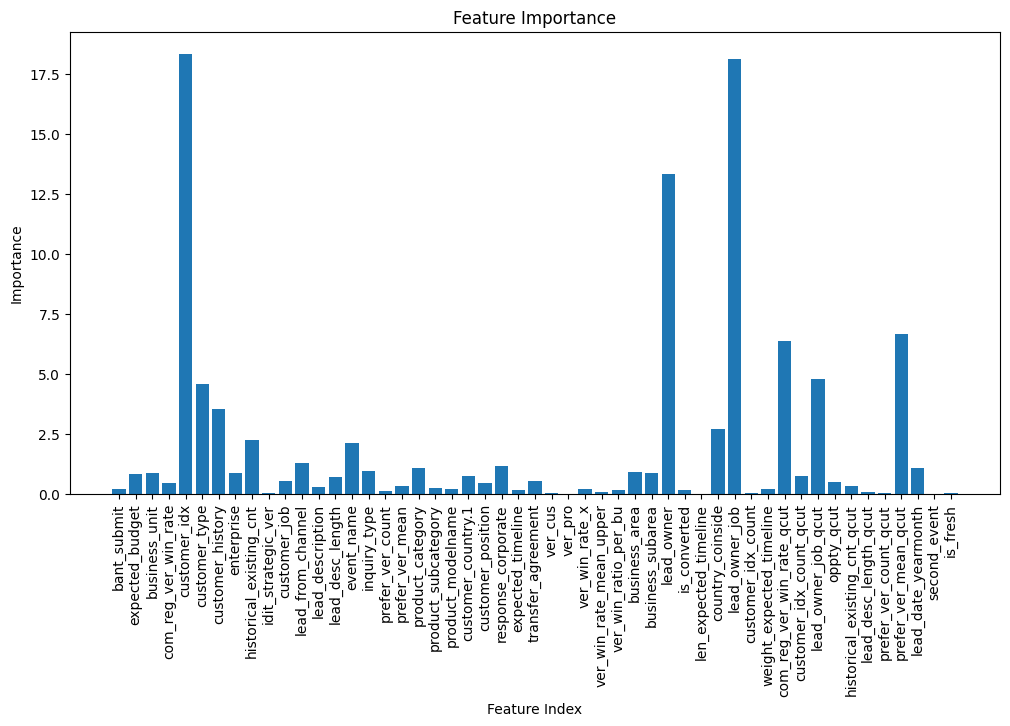

Learning rate set to 0.026101
0:	learn: 0.6590235	test: 0.6586177	best: 0.6586177 (0)	total: 22.6ms	remaining: 1m 53s
1:	learn: 0.6252512	test: 0.6233078	best: 0.6233078 (1)	total: 40.6ms	remaining: 1m 41s
2:	learn: 0.5966560	test: 0.5943659	best: 0.5943659 (2)	total: 60.6ms	remaining: 1m 41s
3:	learn: 0.5640244	test: 0.5594363	best: 0.5594363 (3)	total: 79.9ms	remaining: 1m 39s
4:	learn: 0.5300124	test: 0.5254492	best: 0.5254492 (4)	total: 98.5ms	remaining: 1m 38s
5:	learn: 0.5043831	test: 0.4990134	best: 0.4990134 (5)	total: 118ms	remaining: 1m 38s
6:	learn: 0.4772582	test: 0.4711841	best: 0.4711841 (6)	total: 137ms	remaining: 1m 37s
7:	learn: 0.4585593	test: 0.4524606	best: 0.4524606 (7)	total: 157ms	remaining: 1m 38s
8:	learn: 0.4398108	test: 0.4322559	best: 0.4322559 (8)	total: 175ms	remaining: 1m 36s
9:	learn: 0.4206244	test: 0.4127006	best: 0.4127006 (9)	total: 193ms	remaining: 1m 36s
10:	learn: 0.4053496	test: 0.3970909	best: 0.3970909 (10)	total: 213ms	remaining: 1m 36s
11:	le

94:	learn: 0.1592751	test: 0.1449179	best: 0.1449179 (94)	total: 1.92s	remaining: 1m 39s
95:	learn: 0.1590359	test: 0.1447960	best: 0.1447960 (95)	total: 1.94s	remaining: 1m 38s
96:	learn: 0.1586854	test: 0.1444773	best: 0.1444773 (96)	total: 1.96s	remaining: 1m 38s
97:	learn: 0.1582477	test: 0.1442239	best: 0.1442239 (97)	total: 1.98s	remaining: 1m 38s
98:	learn: 0.1579650	test: 0.1440159	best: 0.1440159 (98)	total: 1.99s	remaining: 1m 38s
99:	learn: 0.1576401	test: 0.1438379	best: 0.1438379 (99)	total: 2.01s	remaining: 1m 38s
100:	learn: 0.1571933	test: 0.1435601	best: 0.1435601 (100)	total: 2.03s	remaining: 1m 38s
101:	learn: 0.1568764	test: 0.1432746	best: 0.1432746 (101)	total: 2.05s	remaining: 1m 38s
102:	learn: 0.1565890	test: 0.1429864	best: 0.1429864 (102)	total: 2.07s	remaining: 1m 38s
103:	learn: 0.1562171	test: 0.1427487	best: 0.1427487 (103)	total: 2.09s	remaining: 1m 38s
104:	learn: 0.1559629	test: 0.1425444	best: 0.1425444 (104)	total: 2.11s	remaining: 1m 38s
105:	learn:

189:	learn: 0.1387359	test: 0.1334843	best: 0.1334843 (189)	total: 3.79s	remaining: 1m 35s
190:	learn: 0.1386668	test: 0.1334399	best: 0.1334399 (190)	total: 3.8s	remaining: 1m 35s
191:	learn: 0.1384937	test: 0.1333863	best: 0.1333863 (191)	total: 3.82s	remaining: 1m 35s
192:	learn: 0.1382951	test: 0.1333056	best: 0.1333056 (192)	total: 3.84s	remaining: 1m 35s
193:	learn: 0.1381003	test: 0.1331847	best: 0.1331847 (193)	total: 3.86s	remaining: 1m 35s
194:	learn: 0.1380164	test: 0.1331109	best: 0.1331109 (194)	total: 3.88s	remaining: 1m 35s
195:	learn: 0.1378294	test: 0.1330586	best: 0.1330586 (195)	total: 3.9s	remaining: 1m 35s
196:	learn: 0.1377546	test: 0.1330148	best: 0.1330148 (196)	total: 3.91s	remaining: 1m 35s
197:	learn: 0.1375980	test: 0.1328980	best: 0.1328980 (197)	total: 3.93s	remaining: 1m 35s
198:	learn: 0.1373921	test: 0.1328757	best: 0.1328757 (198)	total: 3.96s	remaining: 1m 35s
199:	learn: 0.1372683	test: 0.1327864	best: 0.1327864 (199)	total: 3.98s	remaining: 1m 35s
2

286:	learn: 0.1263873	test: 0.1280576	best: 0.1280576 (286)	total: 5.68s	remaining: 1m 33s
287:	learn: 0.1262918	test: 0.1279824	best: 0.1279824 (287)	total: 5.7s	remaining: 1m 33s
288:	learn: 0.1262658	test: 0.1279725	best: 0.1279725 (288)	total: 5.72s	remaining: 1m 33s
289:	learn: 0.1262035	test: 0.1280161	best: 0.1279725 (288)	total: 5.74s	remaining: 1m 33s
290:	learn: 0.1260888	test: 0.1279915	best: 0.1279725 (288)	total: 5.76s	remaining: 1m 33s
291:	learn: 0.1260545	test: 0.1279679	best: 0.1279679 (291)	total: 5.78s	remaining: 1m 33s
292:	learn: 0.1259931	test: 0.1279329	best: 0.1279329 (292)	total: 5.8s	remaining: 1m 33s
293:	learn: 0.1258057	test: 0.1279054	best: 0.1279054 (293)	total: 5.83s	remaining: 1m 33s
294:	learn: 0.1256925	test: 0.1278863	best: 0.1278863 (294)	total: 5.85s	remaining: 1m 33s
295:	learn: 0.1255865	test: 0.1278903	best: 0.1278863 (294)	total: 5.87s	remaining: 1m 33s
296:	learn: 0.1255059	test: 0.1278534	best: 0.1278534 (296)	total: 5.89s	remaining: 1m 33s
2

380:	learn: 0.1167835	test: 0.1244776	best: 0.1244776 (380)	total: 7.58s	remaining: 1m 31s
381:	learn: 0.1166964	test: 0.1244614	best: 0.1244614 (381)	total: 7.61s	remaining: 1m 31s
382:	learn: 0.1165709	test: 0.1243930	best: 0.1243930 (382)	total: 7.63s	remaining: 1m 31s
383:	learn: 0.1164799	test: 0.1244279	best: 0.1243930 (382)	total: 7.65s	remaining: 1m 31s
384:	learn: 0.1163815	test: 0.1244309	best: 0.1243930 (382)	total: 7.67s	remaining: 1m 31s
385:	learn: 0.1161545	test: 0.1242669	best: 0.1242669 (385)	total: 7.69s	remaining: 1m 31s
386:	learn: 0.1160741	test: 0.1242374	best: 0.1242374 (386)	total: 7.71s	remaining: 1m 31s
387:	learn: 0.1160205	test: 0.1242139	best: 0.1242139 (387)	total: 7.73s	remaining: 1m 31s
388:	learn: 0.1159099	test: 0.1242429	best: 0.1242139 (387)	total: 7.76s	remaining: 1m 31s
389:	learn: 0.1158781	test: 0.1242494	best: 0.1242139 (387)	total: 7.78s	remaining: 1m 31s
390:	learn: 0.1156525	test: 0.1240930	best: 0.1240930 (390)	total: 7.8s	remaining: 1m 31s


474:	learn: 0.1092118	test: 0.1219752	best: 0.1219752 (474)	total: 9.49s	remaining: 1m 30s
475:	learn: 0.1091741	test: 0.1219559	best: 0.1219559 (475)	total: 9.51s	remaining: 1m 30s
476:	learn: 0.1091145	test: 0.1219102	best: 0.1219102 (476)	total: 9.52s	remaining: 1m 30s
477:	learn: 0.1090264	test: 0.1218846	best: 0.1218846 (477)	total: 9.54s	remaining: 1m 30s
478:	learn: 0.1089772	test: 0.1218512	best: 0.1218512 (478)	total: 9.56s	remaining: 1m 30s
479:	learn: 0.1089251	test: 0.1218457	best: 0.1218457 (479)	total: 9.59s	remaining: 1m 30s
480:	learn: 0.1088139	test: 0.1217661	best: 0.1217661 (480)	total: 9.6s	remaining: 1m 30s
481:	learn: 0.1088003	test: 0.1217636	best: 0.1217636 (481)	total: 9.62s	remaining: 1m 30s
482:	learn: 0.1087004	test: 0.1216873	best: 0.1216873 (482)	total: 9.64s	remaining: 1m 30s
483:	learn: 0.1086480	test: 0.1217010	best: 0.1216873 (482)	total: 9.66s	remaining: 1m 30s
484:	learn: 0.1085470	test: 0.1216534	best: 0.1216534 (484)	total: 9.68s	remaining: 1m 30s


568:	learn: 0.1037046	test: 0.1202548	best: 0.1202548 (568)	total: 11.4s	remaining: 1m 28s
569:	learn: 0.1035697	test: 0.1201188	best: 0.1201188 (569)	total: 11.4s	remaining: 1m 28s
570:	learn: 0.1035200	test: 0.1201133	best: 0.1201133 (570)	total: 11.4s	remaining: 1m 28s
571:	learn: 0.1034593	test: 0.1200789	best: 0.1200789 (571)	total: 11.4s	remaining: 1m 28s
572:	learn: 0.1034171	test: 0.1200926	best: 0.1200789 (571)	total: 11.5s	remaining: 1m 28s
573:	learn: 0.1033923	test: 0.1200863	best: 0.1200789 (571)	total: 11.5s	remaining: 1m 28s
574:	learn: 0.1032832	test: 0.1199607	best: 0.1199607 (574)	total: 11.5s	remaining: 1m 28s
575:	learn: 0.1032160	test: 0.1199573	best: 0.1199573 (575)	total: 11.5s	remaining: 1m 28s
576:	learn: 0.1032072	test: 0.1199595	best: 0.1199573 (575)	total: 11.5s	remaining: 1m 28s
577:	learn: 0.1031638	test: 0.1199527	best: 0.1199527 (577)	total: 11.6s	remaining: 1m 28s
578:	learn: 0.1031594	test: 0.1199498	best: 0.1199498 (578)	total: 11.6s	remaining: 1m 28s

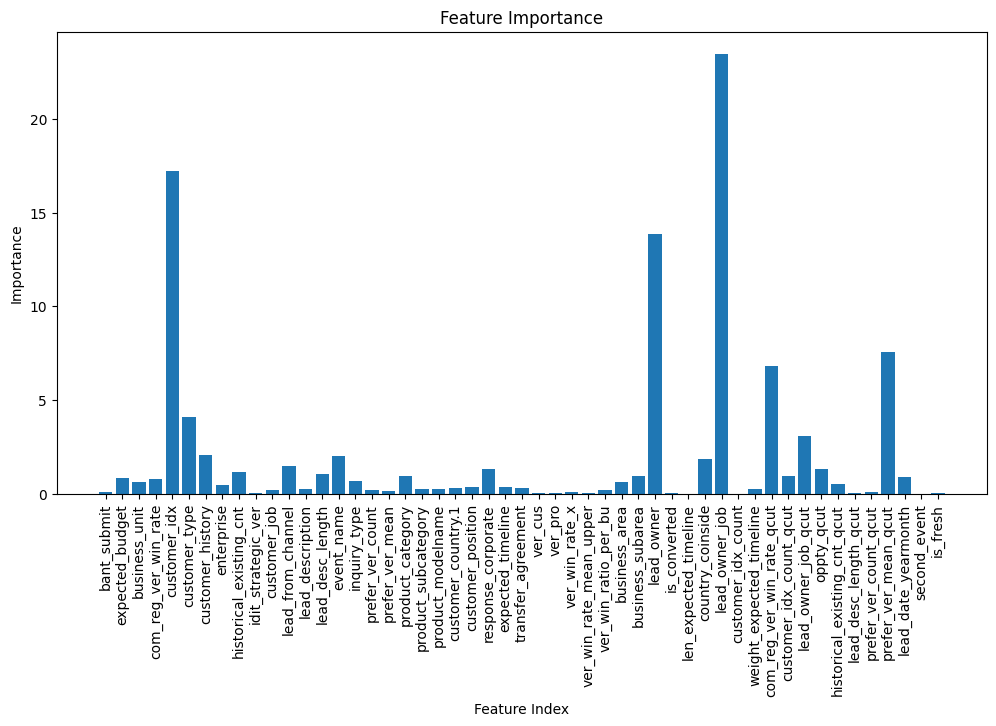

Learning rate set to 0.026101
0:	learn: 0.6534313	test: 0.6520718	best: 0.6520718 (0)	total: 25.4ms	remaining: 2m 7s
1:	learn: 0.6219537	test: 0.6205526	best: 0.6205526 (1)	total: 47.5ms	remaining: 1m 58s
2:	learn: 0.5850066	test: 0.5833561	best: 0.5833561 (2)	total: 65.1ms	remaining: 1m 48s
3:	learn: 0.5531296	test: 0.5506890	best: 0.5506890 (3)	total: 85.1ms	remaining: 1m 46s
4:	learn: 0.5240580	test: 0.5214210	best: 0.5214210 (4)	total: 108ms	remaining: 1m 47s
5:	learn: 0.4962686	test: 0.4923637	best: 0.4923637 (5)	total: 127ms	remaining: 1m 45s
6:	learn: 0.4707078	test: 0.4662973	best: 0.4662973 (6)	total: 147ms	remaining: 1m 45s
7:	learn: 0.4479295	test: 0.4431886	best: 0.4431886 (7)	total: 171ms	remaining: 1m 46s
8:	learn: 0.4297890	test: 0.4251664	best: 0.4251664 (8)	total: 192ms	remaining: 1m 46s
9:	learn: 0.4115216	test: 0.4070461	best: 0.4070461 (9)	total: 213ms	remaining: 1m 46s
10:	learn: 0.3933913	test: 0.3886989	best: 0.3886989 (10)	total: 233ms	remaining: 1m 45s
11:	lear

93:	learn: 0.1563870	test: 0.1472314	best: 0.1472314 (93)	total: 1.88s	remaining: 1m 38s
94:	learn: 0.1558535	test: 0.1468981	best: 0.1468981 (94)	total: 1.9s	remaining: 1m 38s
95:	learn: 0.1555591	test: 0.1468590	best: 0.1468590 (95)	total: 1.92s	remaining: 1m 38s
96:	learn: 0.1553334	test: 0.1467558	best: 0.1467558 (96)	total: 1.94s	remaining: 1m 38s
97:	learn: 0.1550690	test: 0.1466109	best: 0.1466109 (97)	total: 1.96s	remaining: 1m 38s
98:	learn: 0.1546079	test: 0.1461945	best: 0.1461945 (98)	total: 1.98s	remaining: 1m 38s
99:	learn: 0.1541537	test: 0.1457197	best: 0.1457197 (99)	total: 2s	remaining: 1m 38s
100:	learn: 0.1538591	test: 0.1453551	best: 0.1453551 (100)	total: 2.02s	remaining: 1m 38s
101:	learn: 0.1535438	test: 0.1451682	best: 0.1451682 (101)	total: 2.04s	remaining: 1m 38s
102:	learn: 0.1532897	test: 0.1449965	best: 0.1449965 (102)	total: 2.06s	remaining: 1m 38s
103:	learn: 0.1529172	test: 0.1447664	best: 0.1447664 (103)	total: 2.08s	remaining: 1m 38s
104:	learn: 0.152

187:	learn: 0.1356379	test: 0.1332850	best: 0.1332850 (187)	total: 3.76s	remaining: 1m 36s
188:	learn: 0.1354506	test: 0.1332171	best: 0.1332171 (188)	total: 3.77s	remaining: 1m 36s
189:	learn: 0.1352873	test: 0.1331867	best: 0.1331867 (189)	total: 3.79s	remaining: 1m 36s
190:	learn: 0.1350854	test: 0.1329944	best: 0.1329944 (190)	total: 3.81s	remaining: 1m 36s
191:	learn: 0.1350854	test: 0.1329943	best: 0.1329943 (191)	total: 3.82s	remaining: 1m 35s
192:	learn: 0.1349663	test: 0.1328570	best: 0.1328570 (192)	total: 3.83s	remaining: 1m 35s
193:	learn: 0.1348506	test: 0.1328381	best: 0.1328381 (193)	total: 3.85s	remaining: 1m 35s
194:	learn: 0.1347238	test: 0.1327552	best: 0.1327552 (194)	total: 3.87s	remaining: 1m 35s
195:	learn: 0.1345691	test: 0.1326610	best: 0.1326610 (195)	total: 3.89s	remaining: 1m 35s
196:	learn: 0.1344023	test: 0.1324258	best: 0.1324258 (196)	total: 3.91s	remaining: 1m 35s
197:	learn: 0.1342788	test: 0.1323521	best: 0.1323521 (197)	total: 3.93s	remaining: 1m 35s

288:	learn: 0.1243000	test: 0.1275106	best: 0.1275066 (287)	total: 5.69s	remaining: 1m 32s
289:	learn: 0.1241735	test: 0.1274873	best: 0.1274873 (289)	total: 5.71s	remaining: 1m 32s
290:	learn: 0.1240585	test: 0.1275285	best: 0.1274873 (289)	total: 5.73s	remaining: 1m 32s
291:	learn: 0.1239362	test: 0.1274680	best: 0.1274680 (291)	total: 5.75s	remaining: 1m 32s
292:	learn: 0.1239107	test: 0.1274506	best: 0.1274506 (292)	total: 5.77s	remaining: 1m 32s
293:	learn: 0.1237886	test: 0.1274634	best: 0.1274506 (292)	total: 5.79s	remaining: 1m 32s
294:	learn: 0.1237886	test: 0.1274633	best: 0.1274506 (292)	total: 5.79s	remaining: 1m 32s
295:	learn: 0.1236863	test: 0.1274106	best: 0.1274106 (295)	total: 5.81s	remaining: 1m 32s
296:	learn: 0.1236863	test: 0.1274101	best: 0.1274101 (296)	total: 5.82s	remaining: 1m 32s
297:	learn: 0.1235454	test: 0.1273187	best: 0.1273187 (297)	total: 5.84s	remaining: 1m 32s
298:	learn: 0.1233949	test: 0.1272103	best: 0.1272103 (298)	total: 5.86s	remaining: 1m 32s

386:	learn: 0.1176513	test: 0.1251100	best: 0.1251100 (386)	total: 7.57s	remaining: 1m 30s
387:	learn: 0.1176462	test: 0.1251111	best: 0.1251100 (386)	total: 7.59s	remaining: 1m 30s
388:	learn: 0.1176309	test: 0.1251134	best: 0.1251100 (386)	total: 7.61s	remaining: 1m 30s
389:	learn: 0.1175531	test: 0.1250686	best: 0.1250686 (389)	total: 7.63s	remaining: 1m 30s
390:	learn: 0.1174540	test: 0.1250068	best: 0.1250068 (390)	total: 7.66s	remaining: 1m 30s
391:	learn: 0.1174264	test: 0.1250095	best: 0.1250068 (390)	total: 7.68s	remaining: 1m 30s
392:	learn: 0.1173407	test: 0.1249995	best: 0.1249995 (392)	total: 7.7s	remaining: 1m 30s
393:	learn: 0.1172003	test: 0.1249905	best: 0.1249905 (393)	total: 7.72s	remaining: 1m 30s
394:	learn: 0.1171019	test: 0.1249439	best: 0.1249439 (394)	total: 7.75s	remaining: 1m 30s
395:	learn: 0.1170039	test: 0.1248829	best: 0.1248829 (395)	total: 7.77s	remaining: 1m 30s
396:	learn: 0.1168944	test: 0.1248861	best: 0.1248829 (395)	total: 7.79s	remaining: 1m 30s


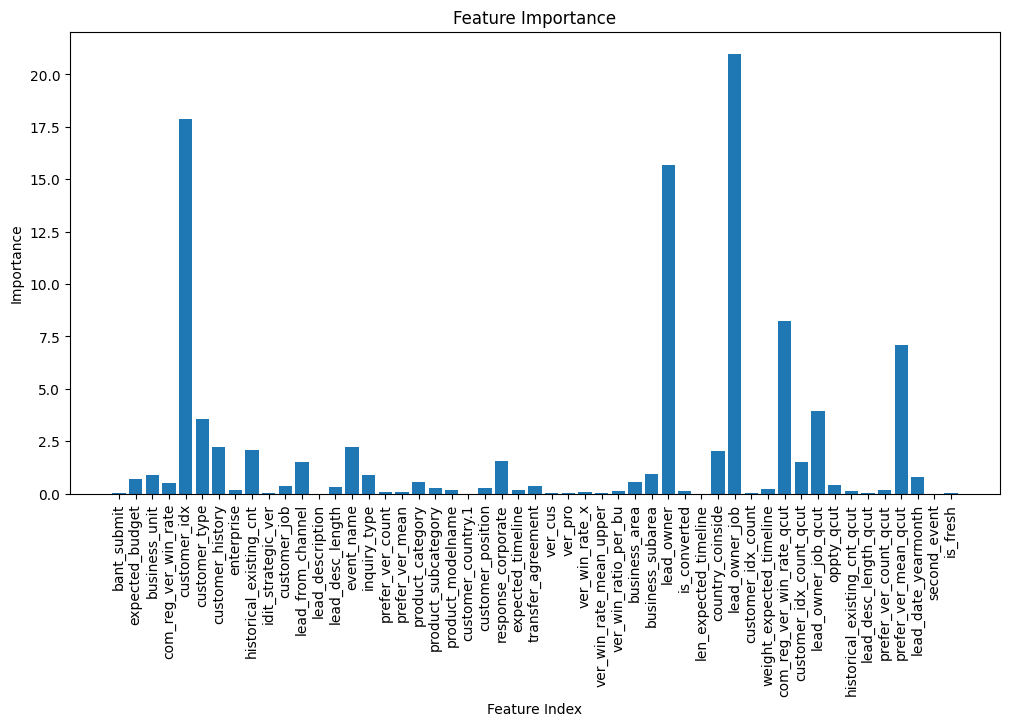

Learning rate set to 0.026101
0:	learn: 0.6535788	test: 0.6532714	best: 0.6532714 (0)	total: 41.5ms	remaining: 3m 27s
1:	learn: 0.6139648	test: 0.6138005	best: 0.6138005 (1)	total: 74.7ms	remaining: 3m 6s
2:	learn: 0.5806671	test: 0.5805004	best: 0.5805004 (2)	total: 107ms	remaining: 2m 58s
3:	learn: 0.5533321	test: 0.5525631	best: 0.5525631 (3)	total: 129ms	remaining: 2m 41s
4:	learn: 0.5245955	test: 0.5238848	best: 0.5238848 (4)	total: 150ms	remaining: 2m 29s
5:	learn: 0.4991730	test: 0.4981456	best: 0.4981456 (5)	total: 166ms	remaining: 2m 18s
6:	learn: 0.4687065	test: 0.4680405	best: 0.4680405 (6)	total: 183ms	remaining: 2m 10s
7:	learn: 0.4475276	test: 0.4468293	best: 0.4468293 (7)	total: 202ms	remaining: 2m 5s
8:	learn: 0.4232517	test: 0.4222776	best: 0.4222776 (8)	total: 218ms	remaining: 2m
9:	learn: 0.4064423	test: 0.4054853	best: 0.4054853 (9)	total: 237ms	remaining: 1m 58s
10:	learn: 0.3938454	test: 0.3927531	best: 0.3927531 (10)	total: 256ms	remaining: 1m 56s
11:	learn: 0.37

92:	learn: 0.1526217	test: 0.1533807	best: 0.1533807 (92)	total: 1.92s	remaining: 1m 41s
93:	learn: 0.1521411	test: 0.1527318	best: 0.1527318 (93)	total: 1.94s	remaining: 1m 41s
94:	learn: 0.1517064	test: 0.1524963	best: 0.1524963 (94)	total: 1.96s	remaining: 1m 41s
95:	learn: 0.1515919	test: 0.1524157	best: 0.1524157 (95)	total: 1.98s	remaining: 1m 41s
96:	learn: 0.1511379	test: 0.1519368	best: 0.1519368 (96)	total: 2s	remaining: 1m 41s
97:	learn: 0.1508530	test: 0.1517796	best: 0.1517796 (97)	total: 2.03s	remaining: 1m 41s
98:	learn: 0.1506447	test: 0.1517272	best: 0.1517272 (98)	total: 2.04s	remaining: 1m 41s
99:	learn: 0.1499862	test: 0.1511717	best: 0.1511717 (99)	total: 2.07s	remaining: 1m 41s
100:	learn: 0.1495854	test: 0.1507736	best: 0.1507736 (100)	total: 2.09s	remaining: 1m 41s
101:	learn: 0.1493339	test: 0.1506046	best: 0.1506046 (101)	total: 2.12s	remaining: 1m 41s
102:	learn: 0.1489680	test: 0.1502775	best: 0.1502775 (102)	total: 2.14s	remaining: 1m 41s
103:	learn: 0.1488

185:	learn: 0.1313766	test: 0.1393037	best: 0.1393037 (185)	total: 3.8s	remaining: 1m 38s
186:	learn: 0.1311004	test: 0.1391095	best: 0.1391095 (186)	total: 3.83s	remaining: 1m 38s
187:	learn: 0.1309565	test: 0.1390352	best: 0.1390352 (187)	total: 3.85s	remaining: 1m 38s
188:	learn: 0.1308986	test: 0.1389537	best: 0.1389537 (188)	total: 3.86s	remaining: 1m 38s
189:	learn: 0.1307664	test: 0.1388762	best: 0.1388762 (189)	total: 3.88s	remaining: 1m 38s
190:	learn: 0.1305939	test: 0.1387831	best: 0.1387831 (190)	total: 3.9s	remaining: 1m 38s
191:	learn: 0.1304525	test: 0.1386894	best: 0.1386894 (191)	total: 3.92s	remaining: 1m 38s
192:	learn: 0.1303495	test: 0.1386793	best: 0.1386793 (192)	total: 3.94s	remaining: 1m 38s
193:	learn: 0.1302497	test: 0.1386836	best: 0.1386793 (192)	total: 3.96s	remaining: 1m 38s
194:	learn: 0.1300818	test: 0.1385004	best: 0.1385004 (194)	total: 3.98s	remaining: 1m 38s
195:	learn: 0.1298444	test: 0.1384120	best: 0.1384120 (195)	total: 4s	remaining: 1m 37s
196:

282:	learn: 0.1199387	test: 0.1332491	best: 0.1332491 (282)	total: 5.69s	remaining: 1m 34s
283:	learn: 0.1199252	test: 0.1332549	best: 0.1332491 (282)	total: 5.71s	remaining: 1m 34s
284:	learn: 0.1198423	test: 0.1332042	best: 0.1332042 (284)	total: 5.73s	remaining: 1m 34s
285:	learn: 0.1197706	test: 0.1331740	best: 0.1331740 (285)	total: 5.75s	remaining: 1m 34s
286:	learn: 0.1196890	test: 0.1331628	best: 0.1331628 (286)	total: 5.76s	remaining: 1m 34s
287:	learn: 0.1195463	test: 0.1331248	best: 0.1331248 (287)	total: 5.78s	remaining: 1m 34s
288:	learn: 0.1194314	test: 0.1331195	best: 0.1331195 (288)	total: 5.8s	remaining: 1m 34s
289:	learn: 0.1193429	test: 0.1331214	best: 0.1331195 (288)	total: 5.82s	remaining: 1m 34s
290:	learn: 0.1193291	test: 0.1331185	best: 0.1331185 (290)	total: 5.84s	remaining: 1m 34s
291:	learn: 0.1192401	test: 0.1330719	best: 0.1330719 (291)	total: 5.86s	remaining: 1m 34s
292:	learn: 0.1190275	test: 0.1329894	best: 0.1329894 (292)	total: 5.88s	remaining: 1m 34s


380:	learn: 0.1128700	test: 0.1310394	best: 0.1310172 (377)	total: 7.59s	remaining: 1m 31s
381:	learn: 0.1127247	test: 0.1309777	best: 0.1309777 (381)	total: 7.61s	remaining: 1m 31s
382:	learn: 0.1126749	test: 0.1309616	best: 0.1309616 (382)	total: 7.63s	remaining: 1m 31s
383:	learn: 0.1126128	test: 0.1309276	best: 0.1309276 (383)	total: 7.64s	remaining: 1m 31s
384:	learn: 0.1125913	test: 0.1309054	best: 0.1309054 (384)	total: 7.66s	remaining: 1m 31s
385:	learn: 0.1125135	test: 0.1309169	best: 0.1309054 (384)	total: 7.68s	remaining: 1m 31s
386:	learn: 0.1123829	test: 0.1308548	best: 0.1308548 (386)	total: 7.7s	remaining: 1m 31s
387:	learn: 0.1123813	test: 0.1308570	best: 0.1308548 (386)	total: 7.72s	remaining: 1m 31s
388:	learn: 0.1123764	test: 0.1308465	best: 0.1308465 (388)	total: 7.74s	remaining: 1m 31s
389:	learn: 0.1123334	test: 0.1308585	best: 0.1308465 (388)	total: 7.76s	remaining: 1m 31s
390:	learn: 0.1122858	test: 0.1308407	best: 0.1308407 (390)	total: 7.79s	remaining: 1m 31s


475:	learn: 0.1068960	test: 0.1291392	best: 0.1291392 (475)	total: 9.5s	remaining: 1m 30s
476:	learn: 0.1068194	test: 0.1291168	best: 0.1291168 (476)	total: 9.52s	remaining: 1m 30s
477:	learn: 0.1067333	test: 0.1290559	best: 0.1290559 (477)	total: 9.54s	remaining: 1m 30s
478:	learn: 0.1066744	test: 0.1290309	best: 0.1290309 (478)	total: 9.56s	remaining: 1m 30s
479:	learn: 0.1066718	test: 0.1290297	best: 0.1290297 (479)	total: 9.58s	remaining: 1m 30s
480:	learn: 0.1066139	test: 0.1290112	best: 0.1290112 (480)	total: 9.61s	remaining: 1m 30s
481:	learn: 0.1065261	test: 0.1289736	best: 0.1289736 (481)	total: 9.63s	remaining: 1m 30s
482:	learn: 0.1064860	test: 0.1289739	best: 0.1289736 (481)	total: 9.65s	remaining: 1m 30s
483:	learn: 0.1063771	test: 0.1289768	best: 0.1289736 (481)	total: 9.67s	remaining: 1m 30s
484:	learn: 0.1063567	test: 0.1289818	best: 0.1289736 (481)	total: 9.69s	remaining: 1m 30s
485:	learn: 0.1061651	test: 0.1289701	best: 0.1289701 (485)	total: 9.71s	remaining: 1m 30s


569:	learn: 0.1008208	test: 0.1273300	best: 0.1273300 (569)	total: 11.4s	remaining: 1m 28s
570:	learn: 0.1007185	test: 0.1273451	best: 0.1273300 (569)	total: 11.4s	remaining: 1m 28s
571:	learn: 0.1006219	test: 0.1273317	best: 0.1273300 (569)	total: 11.5s	remaining: 1m 28s
572:	learn: 0.1005670	test: 0.1273126	best: 0.1273126 (572)	total: 11.5s	remaining: 1m 28s
573:	learn: 0.1005215	test: 0.1273005	best: 0.1273005 (573)	total: 11.5s	remaining: 1m 28s
574:	learn: 0.1004898	test: 0.1273090	best: 0.1273005 (573)	total: 11.5s	remaining: 1m 28s
575:	learn: 0.1004067	test: 0.1273040	best: 0.1273005 (573)	total: 11.5s	remaining: 1m 28s
576:	learn: 0.1003700	test: 0.1273166	best: 0.1273005 (573)	total: 11.6s	remaining: 1m 28s
577:	learn: 0.1003323	test: 0.1272867	best: 0.1272867 (577)	total: 11.6s	remaining: 1m 28s
578:	learn: 0.1003229	test: 0.1272675	best: 0.1272675 (578)	total: 11.6s	remaining: 1m 28s
579:	learn: 0.1002650	test: 0.1272782	best: 0.1272675 (578)	total: 11.6s	remaining: 1m 28s

664:	learn: 0.0958299	test: 0.1265795	best: 0.1265795 (664)	total: 13.3s	remaining: 1m 26s
665:	learn: 0.0957756	test: 0.1265560	best: 0.1265560 (665)	total: 13.3s	remaining: 1m 26s
666:	learn: 0.0956732	test: 0.1265623	best: 0.1265560 (665)	total: 13.4s	remaining: 1m 26s
667:	learn: 0.0956652	test: 0.1265628	best: 0.1265560 (665)	total: 13.4s	remaining: 1m 26s
668:	learn: 0.0955674	test: 0.1265390	best: 0.1265390 (668)	total: 13.4s	remaining: 1m 26s
669:	learn: 0.0954100	test: 0.1265814	best: 0.1265390 (668)	total: 13.4s	remaining: 1m 26s
670:	learn: 0.0953894	test: 0.1265422	best: 0.1265390 (668)	total: 13.4s	remaining: 1m 26s
671:	learn: 0.0953468	test: 0.1265293	best: 0.1265293 (671)	total: 13.5s	remaining: 1m 26s
672:	learn: 0.0953134	test: 0.1265373	best: 0.1265293 (671)	total: 13.5s	remaining: 1m 26s
673:	learn: 0.0952563	test: 0.1265585	best: 0.1265293 (671)	total: 13.5s	remaining: 1m 26s
674:	learn: 0.0952235	test: 0.1265298	best: 0.1265293 (671)	total: 13.5s	remaining: 1m 26s

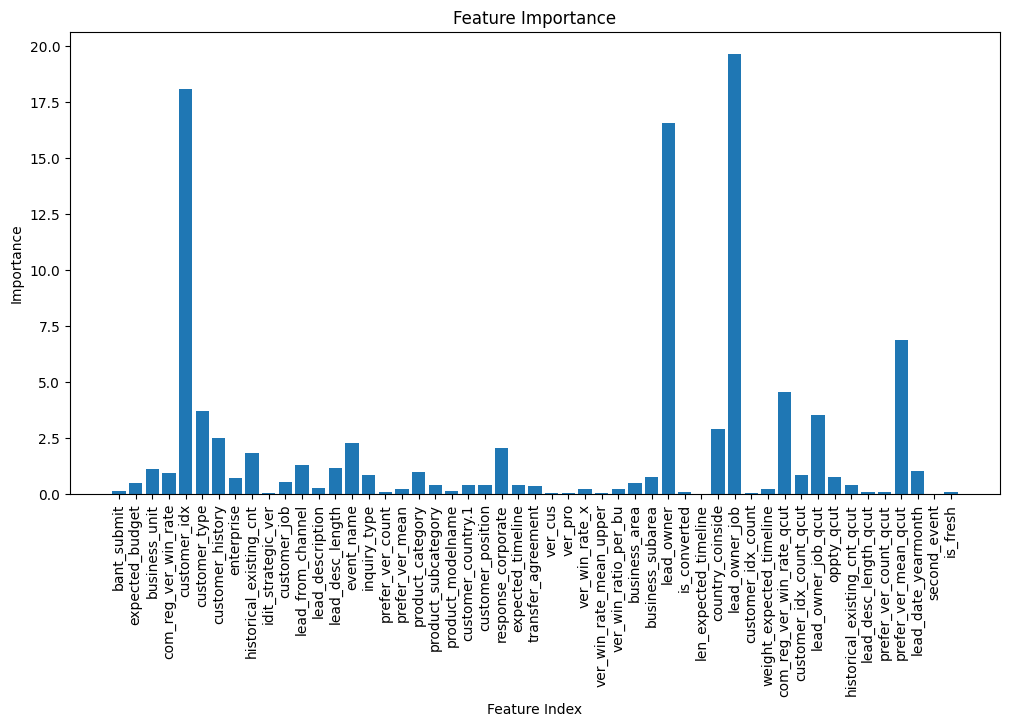

Learning rate set to 0.026101
0:	learn: 0.6506163	test: 0.6504275	best: 0.6504275 (0)	total: 29.7ms	remaining: 2m 28s
1:	learn: 0.6127641	test: 0.6124620	best: 0.6124620 (1)	total: 49.9ms	remaining: 2m 4s
2:	learn: 0.5812011	test: 0.5798466	best: 0.5798466 (2)	total: 67.8ms	remaining: 1m 52s
3:	learn: 0.5511132	test: 0.5495551	best: 0.5495551 (3)	total: 86ms	remaining: 1m 47s
4:	learn: 0.5232139	test: 0.5218551	best: 0.5218551 (4)	total: 105ms	remaining: 1m 45s
5:	learn: 0.5017202	test: 0.4999420	best: 0.4999420 (5)	total: 123ms	remaining: 1m 42s
6:	learn: 0.4761874	test: 0.4749211	best: 0.4749211 (6)	total: 141ms	remaining: 1m 40s
7:	learn: 0.4495266	test: 0.4482534	best: 0.4482534 (7)	total: 160ms	remaining: 1m 40s
8:	learn: 0.4287927	test: 0.4282507	best: 0.4282507 (8)	total: 179ms	remaining: 1m 38s
9:	learn: 0.4116892	test: 0.4111682	best: 0.4111682 (9)	total: 199ms	remaining: 1m 39s
10:	learn: 0.3944993	test: 0.3936729	best: 0.3936729 (10)	total: 218ms	remaining: 1m 38s
11:	learn:

92:	learn: 0.1535418	test: 0.1600257	best: 0.1600257 (92)	total: 1.88s	remaining: 1m 39s
93:	learn: 0.1532055	test: 0.1597768	best: 0.1597768 (93)	total: 1.9s	remaining: 1m 39s
94:	learn: 0.1528123	test: 0.1593406	best: 0.1593406 (94)	total: 1.92s	remaining: 1m 39s
95:	learn: 0.1525164	test: 0.1592028	best: 0.1592028 (95)	total: 1.94s	remaining: 1m 39s
96:	learn: 0.1521603	test: 0.1590147	best: 0.1590147 (96)	total: 1.96s	remaining: 1m 39s
97:	learn: 0.1519465	test: 0.1589392	best: 0.1589392 (97)	total: 1.98s	remaining: 1m 39s
98:	learn: 0.1514293	test: 0.1584523	best: 0.1584523 (98)	total: 2s	remaining: 1m 39s
99:	learn: 0.1509088	test: 0.1578859	best: 0.1578859 (99)	total: 2.03s	remaining: 1m 39s
100:	learn: 0.1502106	test: 0.1571920	best: 0.1571920 (100)	total: 2.05s	remaining: 1m 39s
101:	learn: 0.1499228	test: 0.1569070	best: 0.1569070 (101)	total: 2.07s	remaining: 1m 39s
102:	learn: 0.1493322	test: 0.1562011	best: 0.1562011 (102)	total: 2.09s	remaining: 1m 39s
103:	learn: 0.14901

186:	learn: 0.1283436	test: 0.1432020	best: 0.1432020 (186)	total: 3.78s	remaining: 1m 37s
187:	learn: 0.1281825	test: 0.1431680	best: 0.1431680 (187)	total: 3.8s	remaining: 1m 37s
188:	learn: 0.1280092	test: 0.1429720	best: 0.1429720 (188)	total: 3.81s	remaining: 1m 37s
189:	learn: 0.1278500	test: 0.1427809	best: 0.1427809 (189)	total: 3.83s	remaining: 1m 37s
190:	learn: 0.1276014	test: 0.1426610	best: 0.1426610 (190)	total: 3.85s	remaining: 1m 36s
191:	learn: 0.1274660	test: 0.1426295	best: 0.1426295 (191)	total: 3.87s	remaining: 1m 36s
192:	learn: 0.1272915	test: 0.1426117	best: 0.1426117 (192)	total: 3.89s	remaining: 1m 36s
193:	learn: 0.1271807	test: 0.1426482	best: 0.1426117 (192)	total: 3.91s	remaining: 1m 36s
194:	learn: 0.1271374	test: 0.1426419	best: 0.1426117 (192)	total: 3.93s	remaining: 1m 36s
195:	learn: 0.1270540	test: 0.1425965	best: 0.1425965 (195)	total: 3.95s	remaining: 1m 36s
196:	learn: 0.1269675	test: 0.1425796	best: 0.1425796 (196)	total: 3.97s	remaining: 1m 36s


282:	learn: 0.1161367	test: 0.1389387	best: 0.1389387 (282)	total: 5.66s	remaining: 1m 34s
283:	learn: 0.1161317	test: 0.1389324	best: 0.1389324 (283)	total: 5.66s	remaining: 1m 34s
284:	learn: 0.1159726	test: 0.1388010	best: 0.1388010 (284)	total: 5.68s	remaining: 1m 33s
285:	learn: 0.1158547	test: 0.1387766	best: 0.1387766 (285)	total: 5.7s	remaining: 1m 33s
286:	learn: 0.1158507	test: 0.1387777	best: 0.1387766 (285)	total: 5.71s	remaining: 1m 33s
287:	learn: 0.1157858	test: 0.1387668	best: 0.1387668 (287)	total: 5.73s	remaining: 1m 33s
288:	learn: 0.1155261	test: 0.1386771	best: 0.1386771 (288)	total: 5.75s	remaining: 1m 33s
289:	learn: 0.1153518	test: 0.1386191	best: 0.1386191 (289)	total: 5.77s	remaining: 1m 33s
290:	learn: 0.1153183	test: 0.1385962	best: 0.1385962 (290)	total: 5.79s	remaining: 1m 33s
291:	learn: 0.1152138	test: 0.1384458	best: 0.1384458 (291)	total: 5.81s	remaining: 1m 33s
292:	learn: 0.1151694	test: 0.1384332	best: 0.1384332 (292)	total: 5.83s	remaining: 1m 33s


381:	learn: 0.1079952	test: 0.1358724	best: 0.1358724 (381)	total: 7.57s	remaining: 1m 31s
382:	learn: 0.1078886	test: 0.1358847	best: 0.1358724 (381)	total: 7.59s	remaining: 1m 31s
383:	learn: 0.1078684	test: 0.1358782	best: 0.1358724 (381)	total: 7.62s	remaining: 1m 31s
384:	learn: 0.1078684	test: 0.1358782	best: 0.1358724 (381)	total: 7.63s	remaining: 1m 31s
385:	learn: 0.1077281	test: 0.1358551	best: 0.1358551 (385)	total: 7.65s	remaining: 1m 31s
386:	learn: 0.1077177	test: 0.1358476	best: 0.1358476 (386)	total: 7.68s	remaining: 1m 31s
387:	learn: 0.1076323	test: 0.1358146	best: 0.1358146 (387)	total: 7.7s	remaining: 1m 31s
388:	learn: 0.1075788	test: 0.1358281	best: 0.1358146 (387)	total: 7.72s	remaining: 1m 31s
389:	learn: 0.1075707	test: 0.1358296	best: 0.1358146 (387)	total: 7.74s	remaining: 1m 31s
390:	learn: 0.1074800	test: 0.1357867	best: 0.1357867 (390)	total: 7.76s	remaining: 1m 31s
391:	learn: 0.1073211	test: 0.1357439	best: 0.1357439 (391)	total: 7.79s	remaining: 1m 31s


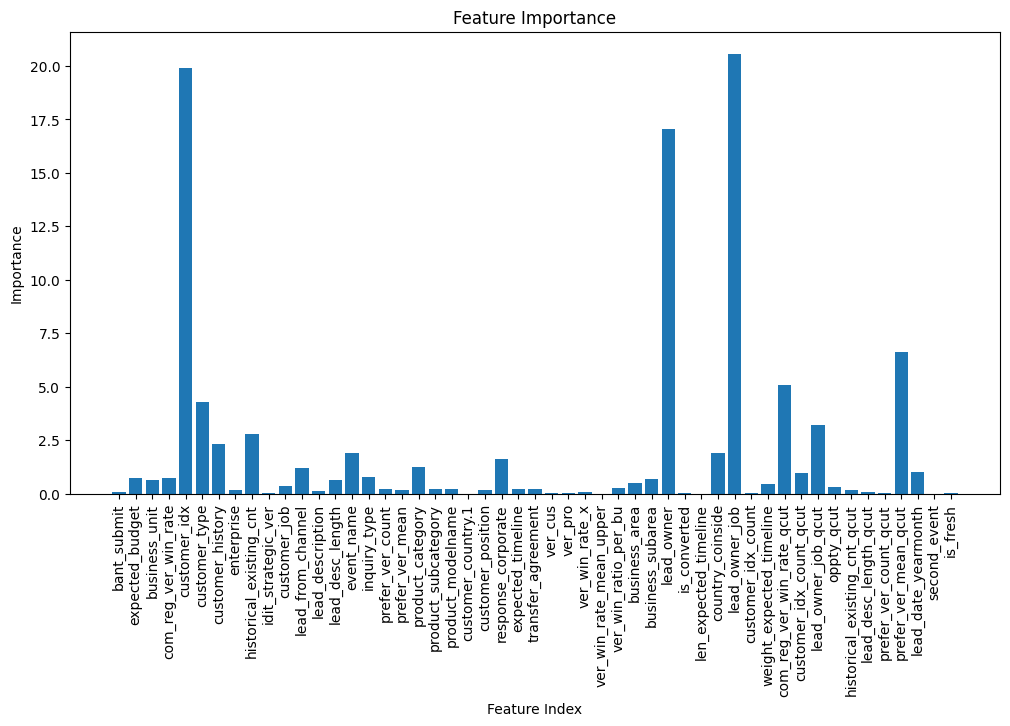

Learning rate set to 0.026101
0:	learn: 0.6470811	test: 0.6455174	best: 0.6455174 (0)	total: 38.6ms	remaining: 3m 13s
1:	learn: 0.6074424	test: 0.6039636	best: 0.6039636 (1)	total: 73.2ms	remaining: 3m 2s
2:	learn: 0.5962659	test: 0.5914791	best: 0.5914791 (2)	total: 83.2ms	remaining: 2m 18s
3:	learn: 0.5676226	test: 0.5609881	best: 0.5609881 (3)	total: 111ms	remaining: 2m 19s
4:	learn: 0.5406535	test: 0.5331087	best: 0.5331087 (4)	total: 127ms	remaining: 2m 7s
5:	learn: 0.5150336	test: 0.5052439	best: 0.5052439 (5)	total: 145ms	remaining: 2m
6:	learn: 0.4870723	test: 0.4763702	best: 0.4763702 (6)	total: 163ms	remaining: 1m 56s
7:	learn: 0.4624653	test: 0.4505777	best: 0.4505777 (7)	total: 179ms	remaining: 1m 51s
8:	learn: 0.4412031	test: 0.4285395	best: 0.4285395 (8)	total: 199ms	remaining: 1m 50s
9:	learn: 0.4215539	test: 0.4089407	best: 0.4089407 (9)	total: 218ms	remaining: 1m 48s
10:	learn: 0.4045826	test: 0.3914215	best: 0.3914215 (10)	total: 238ms	remaining: 1m 48s
11:	learn: 0.3

102:	learn: 0.1532442	test: 0.1407079	best: 0.1407079 (102)	total: 2.09s	remaining: 1m 39s
103:	learn: 0.1530318	test: 0.1406685	best: 0.1406685 (103)	total: 2.1s	remaining: 1m 39s
104:	learn: 0.1526049	test: 0.1403291	best: 0.1403291 (104)	total: 2.13s	remaining: 1m 39s
105:	learn: 0.1521597	test: 0.1398477	best: 0.1398477 (105)	total: 2.15s	remaining: 1m 39s
106:	learn: 0.1516608	test: 0.1392093	best: 0.1392093 (106)	total: 2.17s	remaining: 1m 39s
107:	learn: 0.1513007	test: 0.1387964	best: 0.1387964 (107)	total: 2.19s	remaining: 1m 39s
108:	learn: 0.1509500	test: 0.1386395	best: 0.1386395 (108)	total: 2.21s	remaining: 1m 39s
109:	learn: 0.1506841	test: 0.1385857	best: 0.1385857 (109)	total: 2.23s	remaining: 1m 39s
110:	learn: 0.1502614	test: 0.1383822	best: 0.1383822 (110)	total: 2.26s	remaining: 1m 39s
111:	learn: 0.1499727	test: 0.1381105	best: 0.1381105 (111)	total: 2.28s	remaining: 1m 39s
112:	learn: 0.1497537	test: 0.1380269	best: 0.1380269 (112)	total: 2.3s	remaining: 1m 39s
1

197:	learn: 0.1329043	test: 0.1293498	best: 0.1293498 (197)	total: 3.99s	remaining: 1m 36s
198:	learn: 0.1327687	test: 0.1291701	best: 0.1291701 (198)	total: 4.01s	remaining: 1m 36s
199:	learn: 0.1326870	test: 0.1290728	best: 0.1290728 (199)	total: 4.03s	remaining: 1m 36s
200:	learn: 0.1325936	test: 0.1290397	best: 0.1290397 (200)	total: 4.05s	remaining: 1m 36s
201:	learn: 0.1323960	test: 0.1290208	best: 0.1290208 (201)	total: 4.07s	remaining: 1m 36s
202:	learn: 0.1321447	test: 0.1287967	best: 0.1287967 (202)	total: 4.09s	remaining: 1m 36s
203:	learn: 0.1320509	test: 0.1287581	best: 0.1287581 (203)	total: 4.11s	remaining: 1m 36s
204:	learn: 0.1320495	test: 0.1287578	best: 0.1287578 (204)	total: 4.12s	remaining: 1m 36s
205:	learn: 0.1319277	test: 0.1286512	best: 0.1286512 (205)	total: 4.13s	remaining: 1m 36s
206:	learn: 0.1319203	test: 0.1286512	best: 0.1286512 (206)	total: 4.15s	remaining: 1m 36s
207:	learn: 0.1317577	test: 0.1285344	best: 0.1285344 (207)	total: 4.17s	remaining: 1m 36s

289:	learn: 0.1243922	test: 0.1255513	best: 0.1255513 (289)	total: 5.69s	remaining: 1m 32s
290:	learn: 0.1243367	test: 0.1255154	best: 0.1255154 (290)	total: 5.71s	remaining: 1m 32s
291:	learn: 0.1242729	test: 0.1255073	best: 0.1255073 (291)	total: 5.72s	remaining: 1m 32s
292:	learn: 0.1242169	test: 0.1255113	best: 0.1255073 (291)	total: 5.74s	remaining: 1m 32s
293:	learn: 0.1239760	test: 0.1252838	best: 0.1252838 (293)	total: 5.76s	remaining: 1m 32s
294:	learn: 0.1237870	test: 0.1251714	best: 0.1251714 (294)	total: 5.78s	remaining: 1m 32s
295:	learn: 0.1237364	test: 0.1252006	best: 0.1251714 (294)	total: 5.8s	remaining: 1m 32s
296:	learn: 0.1237020	test: 0.1251663	best: 0.1251663 (296)	total: 5.82s	remaining: 1m 32s
297:	learn: 0.1236523	test: 0.1251626	best: 0.1251626 (297)	total: 5.84s	remaining: 1m 32s
298:	learn: 0.1235202	test: 0.1251090	best: 0.1251090 (298)	total: 5.86s	remaining: 1m 32s
299:	learn: 0.1233513	test: 0.1249989	best: 0.1249989 (299)	total: 5.88s	remaining: 1m 32s


389:	learn: 0.1168924	test: 0.1222003	best: 0.1221798 (388)	total: 7.6s	remaining: 1m 29s
390:	learn: 0.1168766	test: 0.1221977	best: 0.1221798 (388)	total: 7.62s	remaining: 1m 29s
391:	learn: 0.1167177	test: 0.1221181	best: 0.1221181 (391)	total: 7.64s	remaining: 1m 29s
392:	learn: 0.1166261	test: 0.1221012	best: 0.1221012 (392)	total: 7.66s	remaining: 1m 29s
393:	learn: 0.1164244	test: 0.1219646	best: 0.1219646 (393)	total: 7.67s	remaining: 1m 29s
394:	learn: 0.1163420	test: 0.1219424	best: 0.1219424 (394)	total: 7.7s	remaining: 1m 29s
395:	learn: 0.1163016	test: 0.1219474	best: 0.1219424 (394)	total: 7.72s	remaining: 1m 29s
396:	learn: 0.1162905	test: 0.1219419	best: 0.1219419 (396)	total: 7.74s	remaining: 1m 29s
397:	learn: 0.1161326	test: 0.1218402	best: 0.1218402 (397)	total: 7.76s	remaining: 1m 29s
398:	learn: 0.1160304	test: 0.1218361	best: 0.1218361 (398)	total: 7.78s	remaining: 1m 29s
399:	learn: 0.1160242	test: 0.1218510	best: 0.1218361 (398)	total: 7.8s	remaining: 1m 29s
40

484:	learn: 0.1118317	test: 0.1202587	best: 0.1202587 (484)	total: 9.51s	remaining: 1m 28s
485:	learn: 0.1116957	test: 0.1202061	best: 0.1202061 (485)	total: 9.53s	remaining: 1m 28s
486:	learn: 0.1116880	test: 0.1202074	best: 0.1202061 (485)	total: 9.55s	remaining: 1m 28s
487:	learn: 0.1116541	test: 0.1202084	best: 0.1202061 (485)	total: 9.57s	remaining: 1m 28s
488:	learn: 0.1116411	test: 0.1202085	best: 0.1202061 (485)	total: 9.6s	remaining: 1m 28s
489:	learn: 0.1116197	test: 0.1202169	best: 0.1202061 (485)	total: 9.62s	remaining: 1m 28s
490:	learn: 0.1114325	test: 0.1201382	best: 0.1201382 (490)	total: 9.64s	remaining: 1m 28s
491:	learn: 0.1113358	test: 0.1201404	best: 0.1201382 (490)	total: 9.66s	remaining: 1m 28s
492:	learn: 0.1112343	test: 0.1201169	best: 0.1201169 (492)	total: 9.68s	remaining: 1m 28s
493:	learn: 0.1111291	test: 0.1200800	best: 0.1200800 (493)	total: 9.7s	remaining: 1m 28s
494:	learn: 0.1111001	test: 0.1200881	best: 0.1200800 (493)	total: 9.72s	remaining: 1m 28s
4

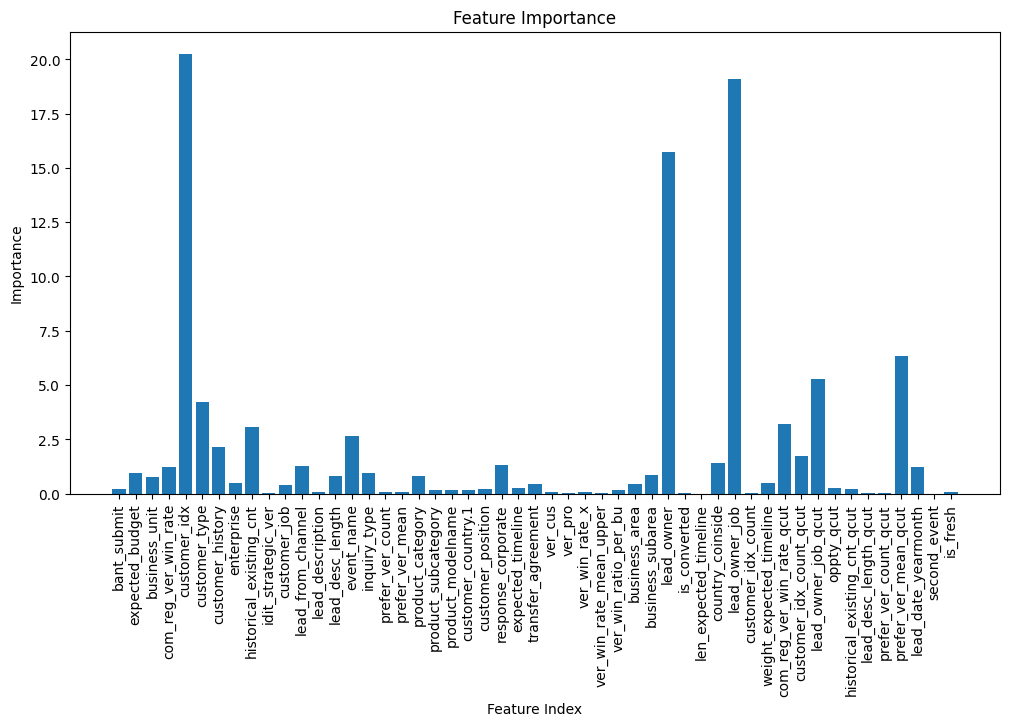

In [27]:
for df_train_bal in train_set:
    x_train, x_val, y_train, y_val = train_test_split(
        df_train_bal.drop(["is_converted"], axis=1),
        df_train_bal["is_converted"],
        test_size=0.2,
        shuffle=True,
        random_state=777,
    )
    # model = CatBoostClassifier(iterations = 5000, cat_features = categorical_cols,  task_type="GPU", random_seed = 777)
    model = CatBoostClassifier(iterations = 5000, cat_features = categorical_cols, random_seed = 777)
    model.fit(x_train.fillna(0), y_train, eval_set = (x_val.fillna(0), y_val), early_stopping_rounds = 10)
    pred = model.predict(x_val.fillna(0))
    y_test, y_pred = y_val, pred
    confusions.append(confusion_matrix(y_test, y_pred, labels=[True, False]))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, labels=[True, False]))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, labels=[True, False]))
    test_preds.append(model.predict_proba(df_test.drop(["is_converted"], axis=1).fillna(0)))
    
    neg_acc = get_neg_acc(y_val, y_pred)
    pos_acc = get_pos_acc(y_val, y_pred)
    
    feature_importances = model.feature_importances_
    
    neg_accs.append(neg_acc)
    pos_accs.append(pos_acc)

    X = df_train_bal.columns[:-1]
    plt.figure(figsize=(12, 6))
    plt.bar(X, feature_importances)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)  # x축 라벨을 90도 회전
    plt.show()

In [28]:
data = {
    'f1': f1_scores,
    'accuracy_scores': accuracy_scores,
    'precision_scores': precision_scores,
    'recall_scores': recall_scores,
    'neg_acc': neg_accs,
    'pos_acc': pos_accs
}
# 데이터프레임 생성
df1 = pd.DataFrame(data)
# 데이터프레임 출력
print(df1)

          f1  accuracy_scores  precision_scores  recall_scores   neg_acc  \
0   0.950052         0.950515          0.925963       0.975427  0.927291   
1   0.950991         0.951546          0.928717       0.974359  0.930279   
2   0.951688         0.952062          0.926188       0.978632  0.927291   
3   0.944792         0.945361          0.921748       0.969017  0.923307   
4   0.944734         0.945361          0.922607       0.967949  0.924303   
5   0.951385         0.952062          0.931423       0.972222  0.933267   
6   0.955929         0.956701          0.939175       0.973291  0.941235   
7   0.952381         0.953093          0.933333       0.972222  0.935259   
8   0.948025         0.948454          0.923077       0.974359  0.924303   
9   0.943435         0.943814          0.917255       0.971154  0.918327   
10  0.950495         0.951031          0.927772       0.974359  0.929283   

     pos_acc  
0   0.975427  
1   0.974359  
2   0.978632  
3   0.969017  
4   0.967949

In [29]:
df1.mean()

f1                  0.949446
accuracy_scores     0.950000
precision_scores    0.927024
recall_scores       0.972999
neg_acc             0.928558
pos_acc             0.972999
dtype: float64

In [30]:
confusions

[array([[913,  23],
        [ 73, 931]]),
 array([[912,  24],
        [ 70, 934]]),
 array([[916,  20],
        [ 73, 931]]),
 array([[907,  29],
        [ 77, 927]]),
 array([[906,  30],
        [ 76, 928]]),
 array([[910,  26],
        [ 67, 937]]),
 array([[911,  25],
        [ 59, 945]]),
 array([[910,  26],
        [ 65, 939]]),
 array([[912,  24],
        [ 76, 928]]),
 array([[909,  27],
        [ 82, 922]]),
 array([[912,  24],
        [ 71, 933]])]

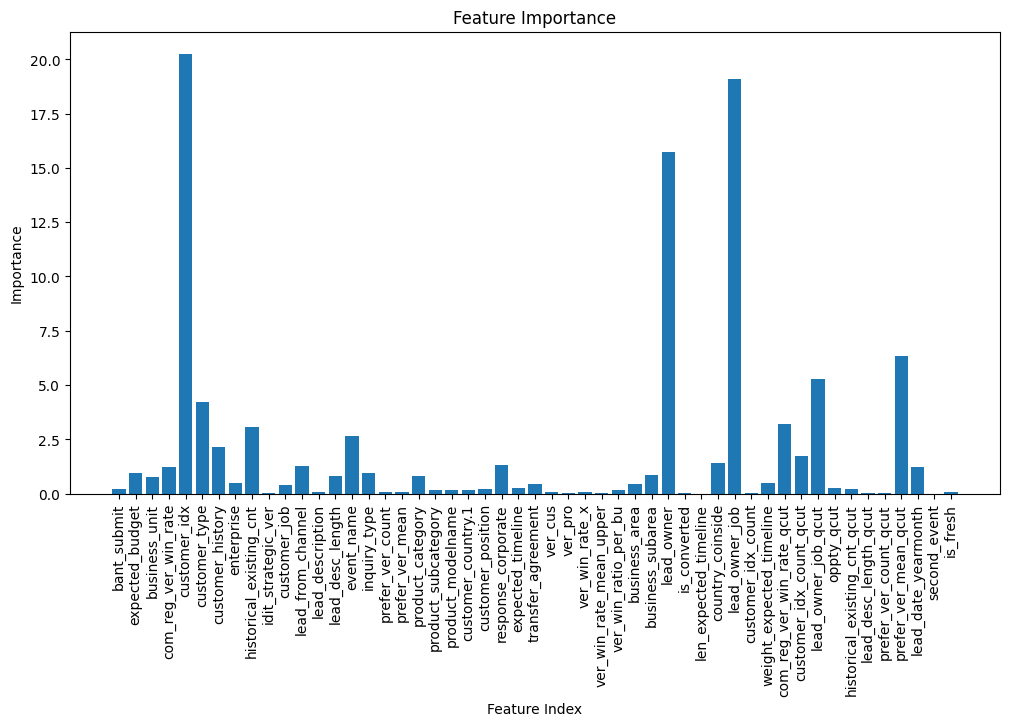

In [31]:
feature_importances = model.feature_importances_

X = df_train_bal.columns[:-1]
plt.figure(figsize=(12, 6))
plt.bar(X, feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)  # x축 라벨을 90도 회전
plt.show()

In [32]:
min_feature_index = np.argmin(feature_importances)
second_min_feature = np.argmin(np.delete(feature_importances, min_feature_index))
print('second:', df_train.columns[second_min_feature], min(feature_importances))
print(df_train.columns[min_feature_index])

second: lead_date_yearmonth 0.0
len_expected_timeline


In [33]:
cat_boost_test_preds = test_preds

## 2. XGBoost

In [34]:
target = "is_converted"
df_train = pd.read_csv("/home/elicer/train.csv") # 학습용 데이터
df_test = pd.read_csv("/home/elicer/submission.csv") # 테스트 데이터(제출파일의 데이터)
df_train[target] = df_train[target].apply(lambda x : 1 if x else 0)

In [35]:
df_test['len_expected_timeline'] = df_test['expected_timeline'].replace('_', ' ')
df_train['len_expected_timeline'] = df_train['expected_timeline'].replace('_', ' ')
def lenfuc(x):
    if isinstance(x,str):
        return len(list(x))
df_test['len_expected_timeline'] = df_test['expected_timeline'].apply(lenfuc)
df_train['len_expected_timeline'] = df_train['expected_timeline'].apply(lenfuc)
df_train['len_expected_timeline'] = df_train['len_expected_timeline'].fillna(0)
df_test['len_expected_timeline'] = df_test['len_expected_timeline'].fillna(0)
def add_countrycoinside(df, customercountry, workcountry, countrycoinside):
    df[countrycoinside] = (df[customercountry] == df[workcountry]).astype(int)
    return df
df_test = add_countrycoinside(df_test, "customer_country", "customer_country.1", "country_coinside")
df_train = add_countrycoinside(df_train, "customer_country", "customer_country.1","country_coinside")
df_train['lead_owner_job'] = df_train.groupby('lead_owner')['lead_owner'].transform('count')
df_test['lead_owner_job'] = df_test.groupby('lead_owner')['lead_owner'].transform('count')
df_train['customer_idx_count'] = df_train.groupby('customer_idx')['customer_idx'].transform('count')
df_test['customer_idx_count'] = df_test.groupby('customer_idx')['customer_idx'].transform('count')
df_train['oppty'] = df_train['customer_idx_count']/df_train['customer_idx_count'].mean() + df_train['lead_owner_job']/df_train['lead_owner_job'].mean()
df_test['oppty'] = df_test['customer_idx_count']/df_test['customer_idx_count'].mean() + df_test['lead_owner_job']/df_test['lead_owner_job'].mean()
# drop_list = ["customer_idx_count"]
# df_test = df_test.drop(drop_list, axis=1)
# df_train = df_train.drop(drop_list, axis=1)
df_train['id_strategic_ver'] = df_train['id_strategic_ver'].fillna(0)
df_train['it_strategic_ver'] = df_train['it_strategic_ver'].fillna(0)
df_test['id_strategic_ver'] = df_test['id_strategic_ver'].fillna(0)
df_test['it_strategic_ver'] = df_test['it_strategic_ver'].fillna(0)
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(0)
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(0)
df_test['ver_cus'] = df_test['ver_cus'].fillna(0)
df_test['ver_cus'] = df_test['ver_cus'].fillna(0)
df_train['vertical_level'] = np.where(((df_train['business_unit']=='ID') & (df_train['id_strategic_ver'] == 0)) | ((df_train['business_unit']=='IT') & (df_train['it_strategic_ver'] == 0)) | (df_train['com_reg_ver_win_rate'] == 0) | ((df_train['ver_cus'] == 0) & (df_train['customer_type'] == 'End-user')) ,0,1)
df_test['vertical_level'] = np.where(((df_test['business_unit']=='ID') & (df_test['id_strategic_ver'] == 0)) | ((df_test['business_unit']=='IT') & (df_test['it_strategic_ver'] == 0)) | (df_test['com_reg_ver_win_rate'] == 0) | ((df_test['ver_cus'] == 0) & (df_test['customer_type'] == 'End-user')) ,0,1)
df_train['expected_timeline'] = df_train['expected_timeline'].fillna('')
df_train['weight_expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 1 if 'month' in x or 'year' in x else 0)
df_test['expected_timeline'] = df_test['expected_timeline'].fillna('')
df_test['weight_expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 1 if 'month' in x or 'year' in x else 0)
df_train['com_reg_ver_win_rate_qcut'] = pd.qcut(df_train['com_reg_ver_win_rate'], 5, labels = False, duplicates = "drop")
df_test['com_reg_ver_win_rate_qcut'] = pd.qcut(df_test['com_reg_ver_win_rate'], 5, labels = False, duplicates = "drop")
df_train['customer_idx_count_qcut'] = pd.qcut(df_train['customer_idx_count'], 5, labels = False, duplicates = "drop")
df_test['customer_idx_count_qcut'] = pd.qcut(df_test['customer_idx_count'], 5, labels = False, duplicates = "drop")
#$ df_train['len_expected_timeline_qcut'] = pd.qcut(df_train['len_expected_timeline'], 5, labels = False, duplicates = "drop")
#$ df_test['len_expected_timeline_qcut'] = pd.qcut(df_test['len_expected_timeline'], 5, labels = False, duplicates = "drop")
df_train['lead_owner_job_qcut'] = pd.qcut(df_train['lead_owner_job'], 5, labels = False, duplicates = "drop")
df_test['lead_owner_job_qcut'] = pd.qcut(df_test['lead_owner_job'], 5, labels = False, duplicates = "drop")
df_train['oppty_qcut'] = pd.qcut(df_train['oppty'], 5, labels = False, duplicates = "drop")
df_test['oppty_qcut'] = pd.qcut(df_test['oppty'], 5, labels = False, duplicates = "drop")
df_train['historical_existing_cnt_qcut'] = pd.qcut(df_train['historical_existing_cnt'], 3, labels = False, duplicates = "drop")
df_test['historical_existing_cnt_qcut'] = pd.qcut(df_test['historical_existing_cnt'], 3, labels = False, duplicates = "drop")
df_train['lead_desc_length_qcut'] = pd.qcut(df_train['lead_desc_length'], 5, labels = False, duplicates = "drop")
df_test['lead_desc_length_qcut'] = pd.qcut(df_test['lead_desc_length'], 5, labels = False, duplicates = "drop")
#df_train['ver_win_rate_x_qcut'] = pd.qcut(df_train['ver_win_rate_x'], 5, labels = False, duplicates = "drop")
#df_test['ver_win_rate_x_qcut'] = pd.qcut(df_test['ver_win_rate_x'], 5, labels = False, duplicates = "drop")
#df_train['ver_win_ratio_per_bu_qcut'] = pd.qcut(df_train['ver_win_ratio_per_bu'], 5, labels = False, duplicates = "drop")
#df_test['ver_win_ratio_per_bu_qcut'] = pd.qcut(df_test['ver_win_ratio_per_bu'], 5, labels = False, duplicates = "drop")
df_train['prefer_ver_count_qcut'] = pd.qcut(df_train['prefer_ver_count'], 3, labels = False, duplicates = "drop")
df_test['prefer_ver_count_qcut'] = pd.qcut(df_test['prefer_ver_count'], 3, labels = False, duplicates = "drop")
df_train['prefer_ver_mean_qcut'] = pd.qcut(df_train['prefer_ver_mean'], 3, labels = False, duplicates = "drop")
df_test['prefer_ver_mean_qcut'] = pd.qcut(df_test['prefer_ver_mean'], 3, labels = False, duplicates = "drop")

def add_vertical1_probability(df):
    df['vertical1_probability'] = (
        ((df['ver_win_ratio_per_bu'] == 1) |
         (df['ver_pro'] == 1) |
         (df['ver_cus'] == 1) |
         (df['idit_strategic_ver'] == 1)) *
        df['prefer_ver_count']
    )

    return df
def add_business_vertical_probability(df):
    df['business_vertical_probability'] = df['com_reg_ver_win_rate'] * df['ver_win_ratio_per_bu']

    return df
#business_area, business_subarea 넣는 함수
def fillna_with_others(df, column):
    df[column].fillna('others', inplace=True)
    return df
#historical_existing_cnt의 결측값 채우기
def fill_na_historical_existing_cnt(df):
    df.loc[(df['customer_history'] == 'New') & (df['historical_existing_cnt'].isna()), 'historical_existing_cnt'] = 0
    return df
#customer_job에 적용
def fillna_with_other(df):
    df['customer_job'] = df['customer_job'].apply(lambda x: 'other' if x == 'others' else x)
    df['customer_job'].fillna('other', inplace=True)
    value_counts = df['customer_job'].value_counts()
    for value, count in value_counts.items():
        if count <= 100:
            df['customer_job'].replace(value, 'other', inplace=True)
    return df


#add_vertical1_probability(df_train)
#add_vertical1_probability(df_test)
#add_business_vertical_probability(df_train)
#add_business_vertical_probability(df_test)
#fillna_with_others(df_train, 'business_area')
#fillna_with_others(df_train, 'business_subarea')
#fillna_with_others(df_test, 'business_area')
#fillna_with_others(df_test, 'business_subarea')
#fill_na_historical_existing_cnt(df_train)
#fill_na_historical_existing_cnt(df_test)
#fillna_with_other(df_train)
#fillna_with_other(df_test)


def derive_year_month(temp_df, temp_df_test) :

    df_ld  = temp_df['lead_date']
    df_ld_test = temp_df_test['lead_date']

    # 연도-월 추출
    ld_year_month = list(map(lambda x : '-'.join(x.split('-')[0:2]), df_ld))
    ld_year_month_test = list(map(lambda x : '-'.join(x.split('-')[0:2]), df_ld_test))
    
    temp_df = temp_df.drop(['lead_date'], axis = 1)
    temp_df_test = temp_df_test.drop(['lead_date'], axis = 1)
    
    temp_df['lead_date_yearmonth'] = ld_year_month
    temp_df_test['lead_date_yearmonth'] = ld_year_month_test
    
    return temp_df, temp_df_test
df_train, df_test = derive_year_month(df_train, df_test)
def add_event_second_feature(df):
    df['second_event'] = df['event_name'].str.split('_', 1).str[1].str.split('_', 1).str[0]
    return df
add_event_second_feature(df_train)
add_event_second_feature(df_test)
def add_is_fresh_feature(df):
    df['is_fresh'] = 0  # 기본값을 'not fresh'로 설정
    # 'customer_history'가 0이고 'historical_existing_cnt'가 결측치인 경우 'fresh'로 설정
    df.loc[(df['customer_history'] == 0) & (df['historical_existing_cnt'].isna()), 'is_fresh'] = 1
    return df
add_is_fresh_feature(df_train)
add_is_fresh_feature(df_test)

/tmp/ipykernel_184344/1308814323.py:126: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df['second_event'] = df['event_name'].str.split('_', 1).str[1].str.split('_', 1).str[0]
/tmp/ipykernel_184344/1308814323.py:126: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df['second_event'] = df['event_name'].str.split('_', 1).str[1].str.split('_', 1).str[0]


,id,bant_submit,expected_budget,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,customer_history,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_from_channel,lead_description,lead_desc_length,event_name,inquiry_type,prefer_ver_count,prefer_ver_mean,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,transfer_agreement,ver_cus,ver_pro,ver_win_rate_x,ver_win_rate_mean_upper,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,len_expected_timeline,country_coinside,lead_owner_job,customer_idx_count,oppty,vertical_level,weight_expected_timeline,com_reg_ver_win_rate_qcut,customer_idx_count_qcut,lead_owner_job_qcut,oppty_qcut,historical_existing_cnt_qcut,lead_desc_length_qcut,prefer_ver_count_qcut,prefer_ver_mean_qcut,lead_date_yearmonth,second_event,is_fresh
0,2547,0.25,NaN,Corporate / /,ID,0.044643,19119,End Customer,New,SMB,NaN,1.0,0.0,1.0,NaN,[premql]us_id__20230701,NaN,309,ID_US_Event_COCC Partners Expo_20230614,Quotation or Purchase Consultation,0.211618,0.027756,NaN,NaN,NaN,Corporate / /,none,LGEUS,,NaN,1,0,0.003079,0.0,0.064566,corporate / office,Others,194,0,0.0,1,833,22,0.923747,1,0,1,2,3,3,NaN,4,1.0,0.0,2023-07,US,0
1,32086,1.00,"Less than $10,000",/ Ahmedabad / India,AS,0.147059,35859,End Customer,New,Enterprise,NaN,0.0,0.0,NaN,administrative,lg.com(local),i have an old system need to be replaced,40,AS_IL_LG.com_I2B_2022,Quotation or Purchase Consultation,0.057692,0.005677,vrf,NaN,NaN,/ Ahmedabad / India,manager,LGEIL,less than 3 months,NaN,1,0,0.000572,0.0,0.051471,education,Institute & Academy,50,1,18.0,1,1,2,0.013143,1,1,1,0,0,0,NaN,3,0.0,0.0,2023-08,IL,0
2,32209,1.00,"$10,000 ~ $50,000",/ 122505 / India,AS,0.461538,38658,End Customer,New,SMB,NaN,0.0,0.0,NaN,engineering,lg.com(local),"WE WANT TO PURCHASE , WHICH WILL BE COMPATIBLE...",76,AS_IL_LG.com_I2B_2022,Quotation or Purchase Consultation,0.076923,0.019648,multi-split,NaN,NaN,/ 122505 / India,manager,LGEIL,less than 3 months,NaN,0,0,0.000060,1.0,0.128571,hospital & health care,Hospital,9,1,18.0,1,80,2,0.088027,1,1,1,0,1,1,NaN,3,0.0,0.0,2023-08,IL,0
3,27680,1.00,OnGoing,/Shiekh Zayed/Egypt,AS,0.000000,29043,End Customer,New,Enterprise,NaN,0.0,0.0,NaN,human resources,facebook,Product estimated budget,24,AS_EG_facebookleadscampaign_May2023,Quotation or Purchase Consultation,NaN,NaN,etc.,NaN,NaN,/Shiekh Zayed/Egypt,director,LGEEG,3 months ~ 6 months,Y,0,0,NaN,NaN,NaN,NaN,NaN,51,0,19.0,1,347,1,0.335018,0,1,0,0,2,2,NaN,2,NaN,NaN,2023-06,EG,0
4,35109,1.00,"Less than $10,000",/Cochin/India,ID,0.028926,42617,Channel Partner,New,SMB,NaN,0.0,0.0,NaN,administrative,lg.com(local),"Lookign for best price, We are doing signage b...",145,ID_IL_LG.com_I2B,Quotation or Purchase Consultation,0.145228,0.103511,standard signage,UH7F-H Series,65UH7F-H,/Cochin/India,ceo/founder,LGEIL,less than 3 months,Y,0,1,0.001183,0.0,0.049840,retail,NaN,174,0,18.0,1,1959,1,1.863028,0,1,0,0,3,3,NaN,4,1.0,2.0,2023-06,IL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21336,26080,0.25,NaN,/ São Paulo / Brazil,AS,0.000000,31080,NaN,New,Enterprise,NaN,0.0,0.0,NaN,others,webinar,N|A,3,AS_SP_Webinar_Integrated_SeminarDate(220322)_C...,NaN,NaN,NaN,multi-split,NaN,NaN,/ São Paulo / Brazil,others,LGESP,,NaN,0,0,NaN,NaN,NaN,NaN,NaN,97,0,0.0,1,3783,1,3.591992,0,0,0,0,4,3,NaN,0,NaN,NaN,2023-07,SP,0
21337,65292,1.00,"$400,000 ~ $600,000",/LIMA/Peru,AS,0.000000,43632,NaN,Existing,SMB,271.0,0.0,0.0,NaN,engineering,webinar,NaN,3,Cursos Online Junio 2023,Others,NaN,NaN,multi-split,NaN,NaN,/LIMA/Peru,others,LGEPR,6 months ~ 9 months,Y,0,0,NaN,NaN,NaN,NaN,NaN,741,0,19.0,1,6,1,0.011785,0,1,0,0,0,0,2.0,0,NaN,NaN,2023-06,NaN,0
21338,27489,1.00,OnGoing,/

In [36]:
# BERT 모델 정의
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
max_seq_len = 128
bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased", from_pt = False)
def sentiment_predict(new_sentence):
  input_id = tokenizer.encode(new_sentence, max_length=max_seq_len, pad_to_max_length=True, truncation = True)

  padding_count = input_id.count(tokenizer.pad_token_id)
  attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
  token_type_id = [0] * max_seq_len

  input_ids = np.array([input_id])
  attention_masks = np.array([attention_mask])
  token_type_ids = np.array([token_type_id])

  encoded_input = [input_ids, attention_masks, token_type_ids]
  score = bert_model.predict(encoded_input)[0]
  return score.mean()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [37]:
less_score = sentiment_predict('less than')
more_score = sentiment_predict('more than')
def score_label(x):
    if 'more' in x:
        return (more_score + 0.5)
    elif 'less' in x:
        return (less_score + 0.5)
    else:
        return 0
df_test['sentimental_expected_timeline'] = df_test['expected_timeline'].apply(score_label)
df_train['sentimental_expected_timeline'] = df_train['expected_timeline'].apply(score_label)

/home/elicer/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


In [38]:
drop_list = ['it_strategic_ver']
df_test = df_test.drop(drop_list, axis=1)
df_train = df_train.drop(drop_list, axis=1)

In [39]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [40]:
numerical_cols, categorical_cols = divide_columns_by_type(df_train)
def move_features(categorical_cols, numerical_cols, features_to_move):
    for feature in features_to_move:
        if feature in numerical_cols:
            categorical_cols.append(feature)
            numerical_cols.remove(feature)
    return categorical_cols, numerical_cols
features_to_move = ['customer_idx', 'lead_owner', 'customer_country.1', 'product_modelname']
updated_categorical_cols, updated_numerical_cols = move_features(categorical_cols, numerical_cols, features_to_move)


In [41]:
# object로 변환
df_all = pd.concat([df_train[categorical_cols], df_test[categorical_cols]])

for col in categorical_cols:
    df_all[[col]] = df_all[[col]].astype(dtype='object')
    df_all[[col]] = df_all[[col]].astype(dtype='category')

for col in categorical_cols:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [42]:
df_all.dtypes

expected_budget        category
customer_country       category
business_unit          category
customer_type          category
customer_history       category
enterprise             category
customer_job           category
lead_from_channel      category
lead_description       category
event_name             category
inquiry_type           category
product_category       category
product_subcategory    category
product_modelname      category
customer_country.1     category
customer_position      category
response_corporate     category
expected_timeline      category
transfer_agreement     category
business_area          category
business_subarea       category
lead_date_yearmonth    category
second_event           category
customer_idx           category
lead_owner             category
dtype: object

In [43]:
df_true = df_train[df_train['is_converted'] == 1]
df_false = df_train[df_train['is_converted'] == 0]

In [44]:
df_false = df_false.sample(frac = 1, random_state= 777)

In [45]:
df_false_set = []
for i in range(int(len(df_false) / len(df_true))):
    df_false_tmp = df_false.iloc[i * len(df_true) : (i+1) * len(df_true)]
    df_false_set.append(df_false_tmp)

In [46]:
train_set = []
for i in range(len(df_false_set)):
    train_data = pd.concat([df_false_set[i], df_true], axis = 0, ignore_index = True)
    train_shuffled = train_data.sample(frac = 1, random_state= 777)
    train_set.append(train_shuffled)

In [47]:
for i in range(len(train_set)):
    if train_set[i]['is_converted'].mean() != 0.5:
        print('오류')

In [48]:
train_set[0].dtypes

bant_submit                       float64
expected_budget                  category
customer_country                 category
business_unit                    category
com_reg_ver_win_rate              float64
customer_idx                     category
customer_type                    category
customer_history                 category
enterprise                       category
historical_existing_cnt           float64
id_strategic_ver                  float64
idit_strategic_ver                float64
customer_job                     category
lead_from_channel                category
lead_description                 category
lead_desc_length                    int64
event_name                       category
inquiry_type                     category
prefer_ver_count                  float64
prefer_ver_mean                   float64
product_category                 category
product_subcategory              category
product_modelname                category
customer_country.1               c

In [49]:
from xgboost import XGBClassifier

In [50]:
# 예측에 필요한 데이터 분리
df_test = df_test.drop(["id"], axis=1)

In [51]:
    f1_scores = []
    accuracy_scores = []
    precision_scores =[]
    recall_scores = []
    neg_accs = []
pos_accs = []
confusions =[]
test_preds = []

In [ ]:
for df_train_bal in train_set:
    x_train, x_val, y_train, y_val = train_test_split(
        df_train_bal.drop(["is_converted"], axis=1),
        df_train_bal["is_converted"],
        test_size=0.2,
        shuffle=True,
        random_state=777,
    )
    #model = CatBoostClassifier(iterations = 5000, cat_features = categorical_cols,  task_type="GPU", random_seed = 777)
    model = XGBClassifier(enable_categorical=True, random_state = 777)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    y_test, y_pred = y_val, pred
    confusions.append(confusion_matrix(y_test, y_pred, labels=[True, False]))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, labels=[True, False]))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, labels=[True, False]))
    neg_acc = get_neg_acc(y_val, y_pred)
    pos_acc = get_pos_acc(y_val, y_pred)
    neg_accs.append(neg_acc)
    pos_accs.append(pos_acc)
    test_preds.append(model.predict_proba(df_test.drop(["is_converted"], axis=1)))

In [ ]:
data = {
    'f1': f1_scores,
    'accuracy_scores': accuracy_scores,
    'precision_scores': precision_scores,
    'recall_scores': recall_scores,
    'neg_acc': neg_accs,
    'pos_acc': pos_accs
}

# 데이터프레임 생성
df2 = pd.DataFrame(data)

# 데이터프레임 출력
print(df2)

In [ ]:
df2.mean()

In [ ]:
feature_importances = model.feature_importances_

X = df_train_bal.columns[:-1]
plt.figure(figsize=(12, 6))
plt.bar(X, feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)  # x축 라벨을 90도 회전
plt.show()

In [ ]:
min_feature_index = np.argmin(feature_importances)
second_min_feature = np.argmin(np.delete(feature_importances, min_feature_index))
print('second:', df_train.columns[second_min_feature], min(feature_importances))
print(df_train.columns[min_feature_index])

# 3. LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
    f1_scores = []
    accuracy_scores = []
    precision_scores =[]
    recall_scores = []
    neg_accs = []
pos_accs = []
confusions =[]
test_preds2 = []

In [ ]:
for df_train_bal in train_set:
    x_train, x_val, y_train, y_val = train_test_split(
        df_train_bal.drop(["is_converted"], axis=1),
        df_train_bal["is_converted"],
        test_size=0.2,
        shuffle=True,
        random_state=777,
    )
    model = lgb.LGBMClassifier(random_state = 777)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    
    print(len(x_train.columns))
    y_test, y_pred = y_val, pred
    confusions.append(confusion_matrix(y_test, y_pred, labels=[True, False]))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, labels=[True, False]))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, labels=[True, False]))

    test_preds2.append(model.predict_proba(df_test.drop(['is_converted'],axis=1)))
    
    
    neg_acc = get_neg_acc(y_val, y_pred)
    pos_acc = get_pos_acc(y_val, y_pred)
    
    feature_importances = model.feature_importances_
    
    neg_accs.append(neg_acc)
    pos_accs.append(pos_acc)

    X = df_train_bal.columns[:-1]
    plt.figure(figsize=(12, 6))
    plt.bar(X, feature_importances)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)  # x축 라벨을 90도 회전
    plt.show()

In [ ]:
data = {
    'f1': f1_scores,
    'accuracy_scores': accuracy_scores,
    'precision_scores': precision_scores,
    'recall_scores': recall_scores,
    'neg_acc': neg_accs,
    'pos_acc': pos_accs
}

# 데이터프레임 생성
df3 = pd.DataFrame(data)

# 데이터프레임 출력
print(df3)

In [ ]:
df3.mean()

In [ ]:
confusions

In [ ]:
feature_importances = model.feature_importances_

X = df_train_bal.columns[:-1]
plt.figure(figsize=(12, 6))
plt.bar(X, feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)  # x축 라벨을 90도 회전
plt.show()

In [ ]:
min_feature_index = np.argmin(feature_importances)
second_min_feature = np.argmin(np.delete(feature_importances, min_feature_index))
print('second:', df_train.columns[second_min_feature], min(feature_importances))
print(df_train.columns[min_feature_index])

# 앙상블

In [ ]:
cat_boost_test_preds = np.array(cat_boost_test_preds)
xgb_test_preds = np.array(test_preds)
light_test_preds = np.array(test_preds2)
# ngb_test_preds = np.array(test_preds3)

In [ ]:
(cat_boost_test_preds + xgb_test_preds + light_test_preds).shape

In [ ]:
test_score = np.zeros((21341, 2))
test_score.shape

In [ ]:
for t in cat_boost_test_preds + xgb_test_preds+ light_test_preds:
    test_score += t
    
test_score

In [ ]:
test_pred = []
for z,o in test_score:
    if z <= o:
        test_pred.append(1)
    else:
        test_pred.append(0)

test_pred

In [ ]:
len(test_pred)

In [ ]:
import pandas as pd
from datetime import datetime
today = datetime.now().strftime("%Y%m%d")

# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("/home/elicer/submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("/home/elicer/submission.csv", index=False)
# df_sub.to_csv(f"submission_{today}_cat+xgb.csv", index=False)

In [ ]:
df_sub['is_converted'].mean()

In [ ]:
# 3개의 모델을 합한 후 평균
((df1 + df2 + df3) / 3).mean()

In [ ]:
df_sub